# 520556528 + 530101303

# Import Libs

In [2]:
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load Datasets

In [107]:
file_path = './Assignment1-Dataset/'

train_X = np.load(file_path + 'train_data.npy')
train_y = np.load(file_path + 'train_label.npy')
test_X = np.load(file_path + 'test_data.npy')
test_y = np.load(file_path + 'test_label.npy')

In [4]:
train_X.shape

(50000, 128)

# Utils

## Test array

In [5]:
test_array = np.random.randn(3, 4)
test_array

array([[-1.2626576 , -0.07343279,  0.19805761, -1.51868025],
       [ 0.39725082, -0.7781142 ,  0.4378592 ,  1.24392688],
       [ 1.81033706, -1.26092481, -1.66679203,  1.05324767]])

## Timer

In [6]:
def timer(func):
    def wrapper(*args, **kwargs):
        print('Start time: ', time.ctime())
        start_time = time.time()  # start time

        result = func(*args, **kwargs)  # run

        end_time = time.time()  # end time
        print('End time: ', time.ctime())
        print(f"{func.__name__} executed in {(end_time - start_time):.4f} seconds")
        return result
    return wrapper

@timer
def test_fun(x):
    time.sleep(x)

test_fun(1)

Start time:  Thu Apr  4 23:36:19 2024
End time:  Thu Apr  4 23:36:20 2024
test_fun executed in 1.0051 seconds


## Kaiming Init

Refer from https://github.com/pytorch/pytorch/blob/main/torch/nn/init.py.

Modify tensor to np.array

In [7]:
def calculate_gain(nonlinearity, param=None):
    r"""Return the recommended gain value for the given nonlinearity function.
    The values are as follows:

    ================= ====================================================
    nonlinearity      gain
    ================= ====================================================
    Linear / Identity :math:`1`
    Conv{1,2,3}D      :math:`1`
    Sigmoid           :math:`1`
    Tanh              :math:`\frac{5}{3}`
    ReLU              :math:`\sqrt{2}`
    Leaky Relu        :math:`\sqrt{\frac{2}{1 + \text{negative\_slope}^2}}`
    SELU              :math:`\frac{3}{4}`
    ================= ====================================================
    """
    
    if nonlinearity == 'sigmoid':
        return 1
    elif nonlinearity == 'tanh':
        return 5.0 / 3
    elif nonlinearity == 'relu':
        return math.sqrt(2.0)
    elif nonlinearity == 'leaky_relu':
        if param is None:
            negative_slope = 0.01
        elif not isinstance(param, bool) and isinstance(param, int) or isinstance(param, float):
            # True/False are instances of int, hence check above
            negative_slope = param
        else:
            raise ValueError(f"negative_slope {param} not a valid number")
        return math.sqrt(2.0 / (1 + negative_slope ** 2))
    elif nonlinearity == 'selu':
        return 3.0 / 4  # Value found empirically (https://github.com/pytorch/pytorch/pull/50664)
    else:
        raise ValueError(f"Unsupported nonlinearity {nonlinearity}")

def _calculate_fan_in_and_fan_out(array):
    dimensions = len(array.shape)
    if dimensions < 2:
        raise ValueError("Fan in and fan out can not be computed for tensor with fewer than 2 dimensions")

    num_input_fmaps = array.shape[1]
    num_output_fmaps = array.shape[0]
    receptive_field_size = 1
    if dimensions > 2:
        # math.prod is not always available, accumulate the product manually
        # we could use functools.reduce but that is not supported by TorchScript
        for s in array.shape[2:]:
            receptive_field_size *= s
    fan_in = num_input_fmaps * receptive_field_size
    fan_out = num_output_fmaps * receptive_field_size

    return fan_in, fan_out

def _calculate_correct_fan(array, mode):
    mode = mode.lower()
    valid_modes = ['fan_in', 'fan_out']
    if mode not in valid_modes:
        raise ValueError(f"Mode {mode} not supported, please use one of {valid_modes}")

    fan_in, fan_out = _calculate_fan_in_and_fan_out(array)
    return fan_in if mode == 'fan_in' else fan_out

def kaiming_normal_(array: np.array, a: float = 0, mode: str = 'fan_in', nonlinearity: str = 'relu'):
    fan = _calculate_correct_fan(array, mode)
    gain = calculate_gain(nonlinearity, a)
    std = gain / math.sqrt(fan)
    return np.random.normal(0, std, array.shape)

kaiming_normal_(np.array([0] * 30).reshape(5, 6))

array([[-0.03728282, -0.42833153, -0.62533594,  0.3412265 , -0.36481554,
         0.83977459],
       [ 0.06735772,  0.2505623 ,  0.90392449,  0.37878901, -0.23172341,
        -0.14801214],
       [-0.72738503,  0.87438122,  0.78539559, -0.61401962, -0.10661531,
         0.28266122],
       [-0.73258472, -0.32651081,  0.28859091, -0.41219357, -0.03792021,
         0.10121226],
       [ 0.69639868,  0.50526404,  0.40791515,  0.12630546,  0.39338233,
         0.27513815]])

## Parameter

In [8]:
class Parameter(object):
    def __init__(self, data, requires_grad, skip_decay=False):
        self.data = data
        self.grad = None
        self.skip_decay = skip_decay
        self.requires_grad = requires_grad

## AverageMeter

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Accuracy

In [10]:
def accuracy(output, target):
    preds = output.argmax(axis=-1, keepdims=True)
    return np.mean(preds == target) * 100

## Pre-process

In [92]:
def get_transform(train_X, test_X, mode=None):
    if mode == 'min-max':
        print('min-max normalization')
        min_each_feature = np.min(train_X, axis=0)
        max_each_feature = np.max(train_X, axis=0)
        scale = max_each_feature - min_each_feature
        scale[scale == 0] = 1   # To avoid divided by 0
        scaled_train = (train_X - min_each_feature) / scale
        scaled_test = (test_X - min_each_feature) / scale
        return scaled_train, scaled_test

    if mode == 'norm':      #TODO: 名称改成standardization
        print('standardization')
        std_each_feature = np.std(train_X, axis=0)
        mean_each_feature = np.mean(train_X, axis=0)
        std_each_feature[std_each_feature == 0] = 1     # To avoid divided by 0
        norm_train = (train_X - mean_each_feature) / std_each_feature
        norm_test = (test_X - mean_each_feature) / std_each_feature
        return norm_train, norm_test

    return train_X, test_X

# Layers

## Base layer

In [12]:
class Layer(object):
    def __init__(self, name, requires_grad=False):
        self.name = name 
        self.requires_grad = requires_grad
        
    def forward(self, *args):
        pass

    def backward(self, *args):
        pass

## Activation

### Relu

In [13]:
class relu(Layer):
    def __init__(self, name, requires_grad=False):
        super().__init__(name, requires_grad)

    def forward(self, input):
        self.input = input
        return np.maximum(0, input)
    
    def backward(self, grad_output):
        grad_output[self.input <= 0] = 0
        return grad_output
    

test_relu = relu('test_relu')
_ = test_relu.forward(test_array)
test_relu.backward(test_array)

array([[0.        , 0.        , 0.19805761, 0.        ],
       [0.39725082, 0.        , 0.4378592 , 1.24392688],
       [1.81033706, 0.        , 0.        , 1.05324767]])

### Leaky Relu

In [14]:
class leaky_relu(Layer):
    def __init__(self, name, alpha, requires_grad=False):
        super().__init__(name, requires_grad)
        self.alpha = alpha

    def forward(self, input):
        self.input = input
        return np.where(input > 0, input, self.alpha * input)
    
    def backward(self, grad_output):
        tmp = np.where(self.input > 0, 1, self.alpha)
        return tmp * grad_output

### Sigmoid

In [15]:
class sigmoid(Layer):
    def __init__(self, name, requires_grad=False):
        super().__init__(name, requires_grad)
        
    def forward(self, input):
        self.y = 1. / (1. + np.exp(-input))   # save sigmoid for more convenient grad computation
        return self.y
    
    def backward(self, grad_output):
        return self.y * (1 - self.y) * grad_output

### Tanh

In [16]:
class tanh(Layer):
    def __init__(self, name, requires_grad=False):
        super().__init__(name, requires_grad)

    def forward(self, input):
        self.y = np.tanh(input)
        return np.tanh(input)
    
    def backward(self, grad_output):
        return (1 - self.y ** 2) * grad_output

### Softmax 

In [17]:
class softmax(Layer):
    def __init__(self, name, requires_grad=False):
        super().__init__(name, requires_grad)
        
    def forward(self, input):
        """
            input.shape = [batch size, num_class]
        """
        x_max = input.max(axis=-1, keepdims=True)       # to avoid overflow
        x_exp = np.exp(input - x_max)
        return x_exp / x_exp.sum(axis=-1, keepdims=True)
    
    def backward(self, grad_output):
        # packaged in CrossEntropyLoss
        return grad_output

softmax('test_softmax').forward(test_array)

array([[0.23702116, 0.23702116, 0.28893652, 0.23702116],
       [0.19819671, 0.13322097, 0.20641081, 0.46217152],
       [0.55672233, 0.09107921, 0.09107921, 0.26111926]])

## Hidden layer

In [18]:
class HiddenLayer(Layer):
    def __init__(self, name, in_num, out_num):
        super().__init__(name, requires_grad=True)
        self.in_num = in_num
        self.out_num = out_num

        W = kaiming_normal_(np.array([0] * in_num * out_num).reshape(in_num, out_num), a=math.sqrt(5))     # Kaiming Init
        self.W = Parameter(W, self.requires_grad)
        self.b = Parameter(np.zeros(out_num), self.requires_grad)

    def forward(self, input):
        self.input = input
        return input @ self.W.data + self.b.data      # [batch size, in_num] @ [in_num, out_num] + [out_num] => [batch size, out_num]
    
    def backward(self, grad_output):
        """
            grad_output: [batch size, out_num]
        """
        batch_size = grad_output.shape[0]
        self.W.grad = self.input.T @ grad_output / batch_size
        self.b.grad = grad_output.sum(axis=0) / batch_size
        return grad_output @ self.W.data.T

# Loss Function

Cross Entropy

In [19]:
class CrossEntropyLoss(object):
    def __init__(self):
        self.softmax = softmax('softmax')

    def __call__(self, input, ground_truth):
        self.bacth_size = input.shape[0]
        self.class_num = input.shape[1]

        preds = self.softmax.forward(input)
        ground_truth = self.one_hot_encoding(ground_truth)

        self.grad = preds - ground_truth    #TODO: 推导要写在report上不？

        loss = -1 * (ground_truth * np.log(preds + 1e-8)).sum() / self.bacth_size

        return loss
    
    def one_hot_encoding(self, x):
        one_hot_encoded = np.zeros((self.bacth_size, self.class_num))
        one_hot_encoded[np.arange(x.size), x.flatten()] = 1
        return one_hot_encoded

# BatchNorm

In [20]:
class batchnorm(Layer):
    def __init__(self, name, shape, requires_grad=True):
        super().__init__(name)
        self.gamma = Parameter(np.random.uniform(0.9, 1.1, shape), requires_grad, skip_decay=True)
        self.beta = Parameter(np.random.uniform(-0.1, 0.1, shape), requires_grad, skip_decay=True)
        self.requires_grad = requires_grad

        self.running_mean = Parameter(np.zeros(shape), False)
        self.running_var = Parameter(np.zeros(shape), False)

    
    def forward(self, input):
        if self.train:
            batch_mean = input.mean(axis=0)
            batch_var = input.var(axis=0)
            batch_std = np.sqrt(batch_var + 1e-8)    # To avoid divided by 0

            momentum = 0.9
            self.running_mean.data = momentum * self.running_mean.data + (1 - momentum) * batch_mean
            self.running_var.data = momentum * self.running_var.data + (1 - momentum) * batch_var
            
        
        else:
            batch_mean = self.running_mean.data
            batch_std = np.sqrt(self.running_var.data)

        self.norm = (input - batch_mean) / batch_std
        self.gamma_norm = self.gamma.data / batch_std

        return self.gamma.data * self.norm + self.beta.data
        
    
    def backward(self, grad_output):        
        batch_size = grad_output.shape[0]
        self.gamma.grad = (grad_output * self.norm).sum(axis=0) / batch_size
        self.beta.grad = grad_output.sum(axis=0) / batch_size
        return self.gamma_norm * (grad_output - self.norm * self.gamma.grad - self.beta.grad)       # TODO: 推导

# Dropout

In [21]:
class dropout(Layer):
    def __init__(self, name, drop_rate, requires_grad=False):
        super().__init__(name, requires_grad)
        self.drop_rate = drop_rate
        self.fix_value = 1 / (1 - self.drop_rate)   # to keep average fixed

    def forward(self, input):
        if self.train:
            self.mask = np.random.uniform(0, 1, input.shape) > self.drop_rate
            return input * self.mask * self.fix_value
        else:
            return input

    def backward(self, grad_output):
        if self.train:
            return grad_output * self.mask
        else:
            return grad_output

# MLP

In [22]:
class MLP(object):
    def __init__(self):
        self.layers = []
        self.params = []
        self.num_layers = 0
    
    def add_layer(self, layer):
        self.layers.append(layer)
        if layer.requires_grad:
            if hasattr(layer, 'W'):
                self.params.append(layer.W)
            if hasattr(layer, 'b'):
                self.params.append(layer.b)
            if hasattr(layer, 'gamma'):
                self.params.append(layer.gamma)
            if hasattr(layer, 'beta'):
                self.params.append(layer.beta)
        self.num_layers += 1

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, x):
        for layer in self.layers[::-1]:
            x = layer.backward(x)
        return x
    
    def train(self):
        for layer in self.layers:
            layer.train = True
    
    def test(self):
        for layer in self.layers:
            layer.train = False

# Optimizer

## SGD with Momentum

In [23]:
class SGD(object):
    def __init__(self, parameters, momentum, lr, weight_decay):
        self.parameters = parameters
        self.momentum = momentum
        self.lr = lr
        self.weight_decay = weight_decay
        self.v = [np.zeros(p.data.shape) for p in self.parameters]

    def step(self):
        for i, (v, p) in enumerate(zip(self.v, self.parameters)):
            if not p.skip_decay:
                p.data -= self.weight_decay * p.data
            v = self.momentum * v + self.lr * p.grad
            self.v[i] = v
            p.data -= self.v[i]

## Adam

In [24]:
class Adam(object):
    def __init__(self, parameters, lr, weight_decay=0, beta=(0.9, 0.999), eps=1e-8):
        self.beta1 = beta[0]
        self.beta2 = beta[1]
        self.lr = lr
        self.weight_decay = weight_decay
        self.eps = eps
        self.parameters = parameters
        self.m = [np.zeros(p.data.shape) for p in self.parameters]
        self.v = [np.zeros(p.data.shape) for p in self.parameters]

        self.iterations = 0
    
    def step(self):
        self.iterations += 1
        for i, (p, m, v) in enumerate(zip(self.parameters, self.m, self.v)):
            if not p.skip_decay:
                p.data -= self.weight_decay * p.data
            m = self.beta1 * m + (1 - self.beta1) * p.grad
            v = self.beta2 * v + (1 - self.beta2) * np.power(p.grad, 2)

            self.m[i] = m
            self.v[i] = v
            
            # bias correction
            m = m / (1 - np.power(self.beta1, self.iterations))
            v = v / (1 - np.power(self.beta2, self.iterations))

            p.data -= self.lr * m / (np.sqrt(v + self.eps))

# Scheduler

## Cosine

In [71]:
class CosineLR(object):
    def __init__(self, optimizer, T_max):
        self.optimizer = optimizer
        self.T_max = T_max
        self.n = -1
        self.base_lr = optimizer.lr
        self.step()

    def step(self):
        self.n += 1
        lr = self.get_lr()
        self.optimizer.lr = lr

    def get_lr(self):
        cos = np.cos(np.pi * self.n / self.T_max)
        return self.base_lr * (1 + cos) / 2

# Trainer

In [73]:
class Trainer(object):
    def __init__(self, config, model=None, train_loader=None, val_loader=None):
        self.config = config
        self.epochs = self.config['epoch']
        self.lr = self.config['lr']
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.print_freq = self.config['print_freq']
        self.scheduler = self.config['scheduler']
        self.train_precs = []
        self.test_precs = []
        self.train_losses = []
        self.test_losses = []

        self.criterion = CrossEntropyLoss()
        if self.config['optimizer'] == 'sgd':
            self.optimizer = SGD(self.model.params, self.config['momentum'], self.lr, self.config['weight_decay'])
        elif self.config['optimizer'] == 'adam':
            self.optimizer = Adam(self.model.params, self.lr, self.config['weight_decay'])
        if self.scheduler:
            self.train_scheduler = CosineLR(self.optimizer, T_max=self.epochs)

    @timer
    def train(self):
        best_acc1 = 0
        for epoch in range(self.epochs):
            print('current lr {:.5e}'.format(self.optimizer.lr))
            self.train_per_epoch(epoch)
            if self.scheduler:
                self.train_scheduler.step()

            # evaluate on validation set
            acc1 = self.validate(epoch)

            # remember best prec@1
            best_acc1 = max(acc1, best_acc1)
            output_best = 'Best Prec@1: %.3f\n' % (best_acc1)
            print(output_best)

    
    def train_per_epoch(self, epoch):
        batch_time = AverageMeter()
        losses = AverageMeter()
        top1 = AverageMeter()

        self.model.train()

        end = time.time()

        for i, (input, target) in enumerate(self.train_loader):
            # compute output
            output = self.model.forward(input)
            loss = self.criterion(output, target)

            # compute gradient and do SGD step
            self.model.backward(self.criterion.grad)
            self.optimizer.step()

            # measure accuracy and record loss
            prec1 = accuracy(output, target)
            losses.update(loss, input.shape[0])
            top1.update(prec1, input.shape[0])

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if (i % self.print_freq == 0) or (i == len(self.train_loader) - 1):
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                    'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                        epoch + 1, i, len(self.train_loader) - 1, batch_time=batch_time,
                        loss=losses, top1=top1))
        
        output = ('EPOCH: {epoch} {flag} Results: Prec@1 {top1.avg:.3f} Loss: {losses.avg:.4f}'.format(epoch=epoch + 1 , flag='train', top1=top1, losses=losses))
        print(output)
        self.train_losses.append(losses.avg)
        self.train_precs.append(top1.avg)
                
    def validate(self, epoch):
        batch_time = AverageMeter()
        losses = AverageMeter()
        top1 = AverageMeter()

        self.model.test()

        end = time.time()
        for i, (input, target) in enumerate(self.val_loader):
            # compute output
            output = self.model.forward(input)
            loss = self.criterion(output, target)

            # measure accuracy and record loss
            prec1 = accuracy(output, target)
            losses.update(loss, input.shape[0])
            top1.update(prec1, input.shape[0])

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if (i % self.print_freq == 0) or (i == len(self.val_loader) - 1):
                print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                    'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                        i, len(self.val_loader) - 1, batch_time=batch_time, loss=losses,
                        top1=top1))
        
        output = ('EPOCH: {epoch} {flag} Results: Prec@1 {top1.avg:.3f} Loss: {losses.avg:.4f}'.format(epoch=epoch + 1 , flag='val', top1=top1, losses=losses))
        print(output)
        self.test_losses.append(losses.avg)
        self.test_precs.append(top1.avg)

        return top1.avg
    
    def plot_cm(self, save_path):
        self.model.test()
        y_pred = []
        y_true = []
        for i, (input, target) in enumerate(self.val_loader):
            # compute output
            output = self.model.forward(input)
            output = np.argmax(output, axis=1)
            y_pred += list(output)
            y_true += list(target.flatten())
            
        cm = confusion_matrix(y_true, y_pred)
        plt.figure()
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.ylabel("Ground Truth")
        plt.xlabel("Prediction")
        plt.savefig(save_path)
        


# Dataloader

In [27]:
class Dataloader(object):
    def __init__(self, X, y, batch_size, shuffle=True, seed=None):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.index = np.arange(X.shape[0])
    
    def __iter__(self):
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.index)
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= len(self.index):
            raise StopIteration
        
        index = self.index[self.n:self.n + self.batch_size]
        batch_X = self.X[index]
        batch_y = self.y[index]
        self.n += self.batch_size

        return batch_X, batch_y
    
    def __len__(self):
        """
            num of batch
        """
        return (len(self.index) + self.batch_size - 1) // self.batch_size  # ceiling

# Main

Configs of Baseline vs Best Model

| Modules                | Baseline          | Best Model |
| ---------------------- | ----------------- | ---------- |
| Batch size             | 128               |            |
| Learning rate          | 0.1               |            |
| Scheduler              | CosineAnnealingLR |            |
| Epoch                  | 100               |            |
| Pre-processing         | Yes               |            |
| Number of Hidden layer | 2                 | 2          |
| Hidden units           | [64, 32]          |            |
| Activations            | [Relu, Relu]      |            |
| Weight initialisation  | Kaiming           | Kaiming    |
| Weight decay           | 5e-4              |            |
| Optimizer              | SGD with Momentum |            |
| Momentum               | 0.9               |            |
| Batch Normalisation    | Yes               |            |
| Dropout rate           | 0.1               |            |
| Accuracy               | 53.03%            |            |

## run!

In [127]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.3}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    {'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.3}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, # cos, None
    'pre-process': None,      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer = Trainer(config, model, train_dataloader, test_dataloader)
trainer.train()

Start time:  Fri Apr  5 20:40:26 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.120 (0.120)	Loss 6.3604 (6.3604)	Prec@1 10.059 (10.059)
Epoch: [1][9/48]	Time 0.025 (0.040)	Loss 5.7673 (6.0833)	Prec@1 10.254 (10.771)
Epoch: [1][18/48]	Time 0.044 (0.036)	Loss 4.9681 (5.7364)	Prec@1 13.867 (11.570)
Epoch: [1][27/48]	Time 0.048 (0.036)	Loss 4.5470 (5.4580)	Prec@1 15.723 (12.266)
Epoch: [1][36/48]	Time 0.033 (0.034)	Loss 4.0316 (5.2018)	Prec@1 16.016 (12.962)
Epoch: [1][45/48]	Time 0.018 (0.031)	Loss 3.9700 (4.9673)	Prec@1 17.578 (13.827)
Epoch: [1][48/48]	Time 0.019 (0.031)	Loss 3.9148 (4.9051)	Prec@1 18.986 (14.072)
EPOCH: 1 train Results: Prec@1 14.072 Loss: 4.9051
Test: [0/9]	Time 0.007 (0.007)	Loss 2.5207 (2.5207)	Prec@1 23.438 (23.438)
Test: [9/9]	Time 0.009 (0.009)	Loss 2.4671 (2.4695)	Prec@1 24.235 (24.160)
EPOCH: 1 val Results: Prec@1 24.160 Loss: 2.4695
Best Prec@1: 24.160

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.051 (0.051)	Loss 3.6886 (3.6886)	Prec@1 18.750 (18.750)


# Plot results

## Confusion Matrix

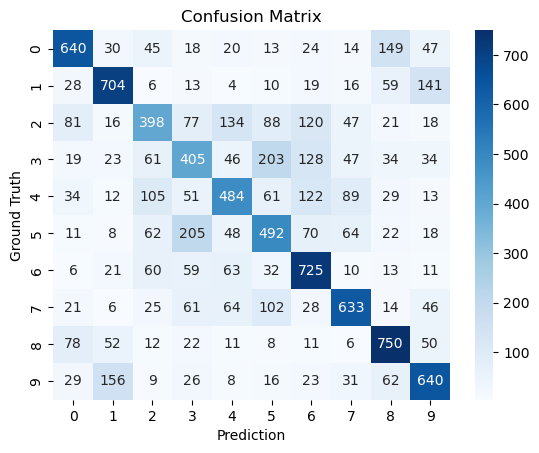

In [128]:
trainer.plot_cm('./figs/cm.png')

## Accuracy

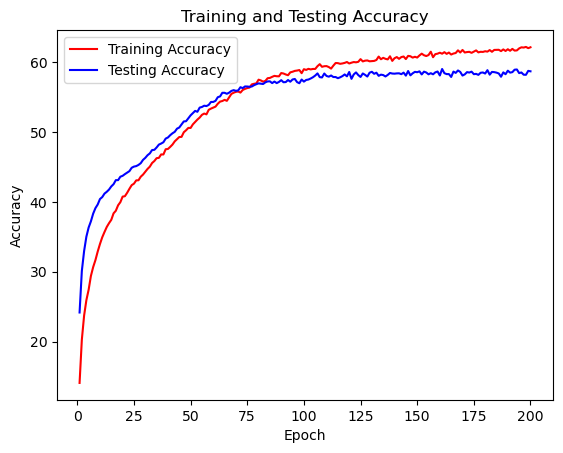

In [129]:
def plot_accuracy(trainer):
    train_accu = trainer.train_precs
    test_accu = trainer.test_precs
    x = [i + 1 for i in range(trainer.epochs)]

    plt.figure()
    plt.plot(x, train_accu, 'r-', label='Training Accuracy')
    plt.plot(x, test_accu, 'b-', label='Testing Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(trainer)

## Loss

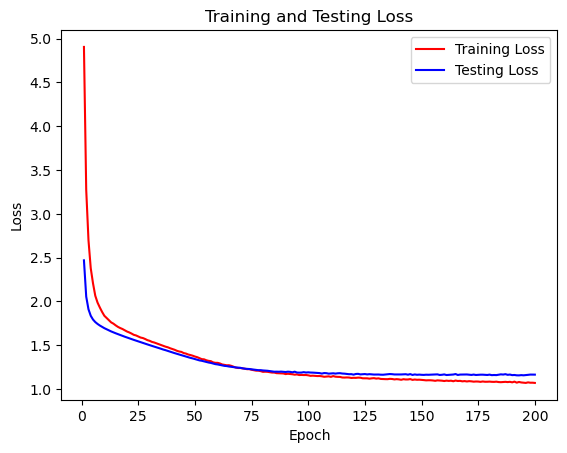

In [130]:
def plot_loss(trainer):
    train_accu = trainer.train_losses
    test_accu = trainer.test_losses
    x = [i + 1 for i in range(trainer.epochs)]

    plt.figure()
    plt.plot(x, train_accu, 'r-', label='Training Loss')
    plt.plot(x, test_accu, 'b-', label='Testing Loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(trainer)

# Baseline vs Best model

baseline

In [136]:
layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 64}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 64}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    {'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 64, 'out_num': 32}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 32}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 32, 'out_num': 10}},
]

bs = 128
config = {
    'layers': layers,
    'lr': 0.1, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 100,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, # cos, None
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer_baseline = Trainer(config, model, train_dataloader, test_dataloader)
trainer_baseline.train()

standardization
Start time:  Fri Apr  5 20:55:01 2024
current lr 1.00000e-01
Epoch: [1][0/390]	Time 0.039 (0.039)	Loss 3.0289 (3.0289)	Prec@1 13.281 (13.281)
Epoch: [1][78/390]	Time 0.001 (0.008)	Loss 1.8684 (2.2484)	Prec@1 35.938 (19.116)
Epoch: [1][156/390]	Time 0.002 (0.005)	Loss 1.9136 (2.0759)	Prec@1 27.344 (24.691)
Epoch: [1][234/390]	Time 0.001 (0.004)	Loss 1.7526 (1.9875)	Prec@1 35.156 (27.550)
Epoch: [1][312/390]	Time 0.001 (0.004)	Loss 1.7463 (1.9275)	Prec@1 38.281 (29.745)
Epoch: [1][390/390]	Time 0.001 (0.004)	Loss 1.7222 (1.8879)	Prec@1 37.500 (31.252)
EPOCH: 1 train Results: Prec@1 31.252 Loss: 1.8879
Test: [0/78]	Time 0.000 (0.000)	Loss 1.5318 (1.5318)	Prec@1 42.188 (42.188)
Test: [78/78]	Time 0.000 (0.000)	Loss 1.6403 (1.6060)	Prec@1 50.000 (41.850)
EPOCH: 1 val Results: Prec@1 41.850 Loss: 1.6060
Best Prec@1: 41.850

current lr 1.00000e-01
Epoch: [2][0/390]	Time 0.001 (0.001)	Loss 1.7095 (1.7095)	Prec@1 34.375 (34.375)
Epoch: [2][78/390]	Time 0.002 (0.001)	Loss 1.6689 

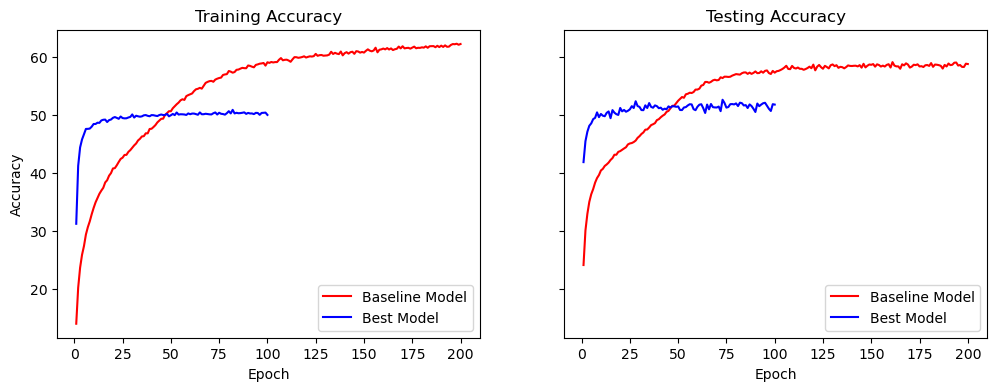

In [137]:
def plot_accuracy(trainers):
    train_accu = [trainer.train_precs for trainer in trainers]
    test_accu = [trainer.test_precs for trainer in trainers]
    lrs = ['Baseline Model', 'Best Model']
    c = ['r-', 'b-']
    x1 = [i + 1 for i in range(trainers[0].epochs)]
    x2 = [i + 1 for i in range(trainers[1].epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    ax1.plot(x1, train_accu[0], c[0], label=lrs[0])
    ax1.plot(x2, train_accu[1], c[1], label=lrs[1])
    

    ax2.plot(x1, test_accu[0], c[0], label=lrs[0])
    ax2.plot(x2, test_accu[1], c[1], label=lrs[1])

    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')

    ax2.set_title('Testing Accuracy')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='lower right')
    ax2.legend(loc='lower right')
    plt.show()

plot_accuracy([trainer, trainer_baseline])

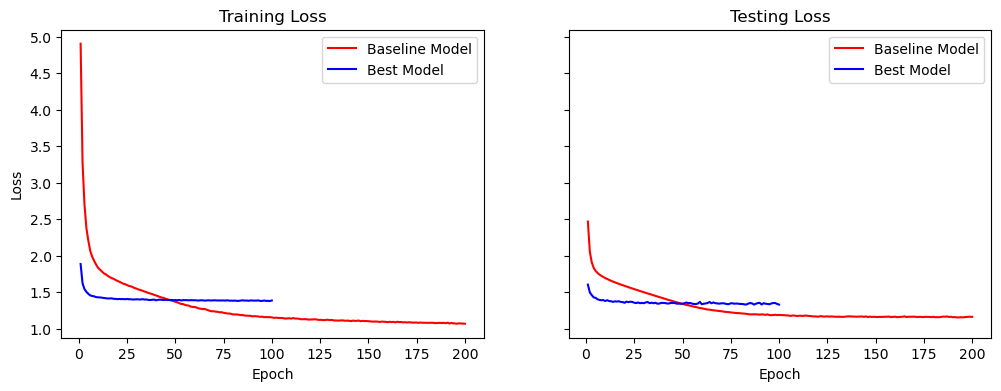

In [138]:
def plot_accuracy(trainers):
    train_accu = [trainer.train_losses for trainer in trainers]
    test_accu = [trainer.test_losses for trainer in trainers]
    lrs = ['Baseline Model', 'Best Model']
    c = ['r-', 'b-']
    x1 = [i + 1 for i in range(trainers[0].epochs)]
    x2 = [i + 1 for i in range(trainers[1].epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    ax1.plot(x1, train_accu[0], c[0], label=lrs[0])
    ax1.plot(x2, train_accu[1], c[1], label=lrs[1])
    

    ax2.plot(x1, test_accu[0], c[0], label=lrs[0])
    ax2.plot(x2, test_accu[1], c[1], label=lrs[1])

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2.set_title('Testing Loss')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    plt.show()

plot_accuracy([trainer, trainer_baseline])

# 调lr

In [283]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 128
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': 'cos', # cos, None
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer2 = Trainer(config, model, train_dataloader, test_dataloader)
trainer2.train()

Start time:  Thu Apr  4 22:55:29 2024
current lr 1.00000e-02
Epoch: [1][0/390]	Time 0.011 (0.011)	Loss 5.5346 (5.5346)	Prec@1 9.375 (9.375)
Epoch: [1][78/390]	Time 0.002 (0.005)	Loss 2.4991 (3.3599)	Prec@1 32.031 (22.636)
Epoch: [1][156/390]	Time 0.009 (0.004)	Loss 2.4369 (2.8159)	Prec@1 24.219 (26.866)
Epoch: [1][234/390]	Time 0.002 (0.004)	Loss 1.9684 (2.5443)	Prec@1 34.375 (29.451)
Epoch: [1][312/390]	Time 0.005 (0.005)	Loss 1.8863 (2.3738)	Prec@1 34.375 (31.178)
Epoch: [1][390/390]	Time 0.001 (0.005)	Loss 1.6280 (2.2570)	Prec@1 41.250 (32.432)
EPOCH: 1 train Results: Prec@1 32.432 Loss: 2.2570
Test: [0/78]	Time 0.001 (0.001)	Loss 1.5203 (1.5203)	Prec@1 47.656 (47.656)
Test: [78/78]	Time 0.000 (0.001)	Loss 1.4963 (1.6156)	Prec@1 31.250 (42.860)
EPOCH: 1 val Results: Prec@1 42.860 Loss: 1.6156
Best Prec@1: 42.860

current lr 1.00000e-02
Epoch: [2][0/390]	Time 0.005 (0.005)	Loss 1.6112 (1.6112)	Prec@1 51.562 (51.562)
Epoch: [2][78/390]	Time 0.002 (0.003)	Loss 1.5126 (1.6195)	Prec@1 45

In [284]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 128
config = {
    'layers': layers,
    'lr': 0.001, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer3 = Trainer(config, model, train_dataloader, test_dataloader)
trainer3.train()

Start time:  Thu Apr  4 23:00:15 2024
current lr 1.00000e-03
Epoch: [1][0/390]	Time 0.006 (0.006)	Loss 5.5346 (5.5346)	Prec@1 9.375 (9.375)
Epoch: [1][78/390]	Time 0.003 (0.004)	Loss 4.2110 (4.8313)	Prec@1 11.719 (12.233)
Epoch: [1][156/390]	Time 0.002 (0.003)	Loss 3.7790 (4.2625)	Prec@1 14.062 (14.734)
Epoch: [1][234/390]	Time 0.006 (0.003)	Loss 2.8561 (3.9043)	Prec@1 25.781 (16.702)
Epoch: [1][312/390]	Time 0.003 (0.003)	Loss 2.9212 (3.6516)	Prec@1 18.750 (18.136)
Epoch: [1][390/390]	Time 0.003 (0.003)	Loss 2.4238 (3.4550)	Prec@1 27.500 (19.672)
EPOCH: 1 train Results: Prec@1 19.672 Loss: 3.4550
Test: [0/78]	Time 0.001 (0.001)	Loss 2.3102 (2.3102)	Prec@1 29.688 (29.688)
Test: [78/78]	Time 0.000 (0.001)	Loss 2.1503 (2.2151)	Prec@1 25.000 (29.720)
EPOCH: 1 val Results: Prec@1 29.720 Loss: 2.2151
Best Prec@1: 29.720

current lr 1.00000e-03
Epoch: [2][0/390]	Time 0.002 (0.002)	Loss 2.5185 (2.5185)	Prec@1 24.219 (24.219)
Epoch: [2][78/390]	Time 0.002 (0.003)	Loss 2.1063 (2.4423)	Prec@1 32

In [285]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 128
config = {
    'layers': layers,
    'lr': 0.005, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer4 = Trainer(config, model, train_dataloader, test_dataloader)
trainer4.train()

Start time:  Thu Apr  4 23:04:39 2024
current lr 5.00000e-03
Epoch: [1][0/390]	Time 0.005 (0.005)	Loss 5.5346 (5.5346)	Prec@1 9.375 (9.375)
Epoch: [1][78/390]	Time 0.002 (0.004)	Loss 2.8495 (3.7941)	Prec@1 25.000 (18.839)
Epoch: [1][156/390]	Time 0.002 (0.004)	Loss 2.8395 (3.1958)	Prec@1 22.656 (23.238)
Epoch: [1][234/390]	Time 0.002 (0.004)	Loss 2.1464 (2.8916)	Prec@1 32.031 (25.967)
Epoch: [1][312/390]	Time 0.003 (0.004)	Loss 2.1551 (2.6953)	Prec@1 27.344 (27.611)
Epoch: [1][390/390]	Time 0.009 (0.004)	Loss 1.8144 (2.5549)	Prec@1 42.500 (28.946)
EPOCH: 1 train Results: Prec@1 28.946 Loss: 2.5549
Test: [0/78]	Time 0.002 (0.002)	Loss 1.6903 (1.6903)	Prec@1 39.062 (39.062)
Test: [78/78]	Time 0.000 (0.001)	Loss 1.6257 (1.7333)	Prec@1 25.000 (39.680)
EPOCH: 1 val Results: Prec@1 39.680 Loss: 1.7333
Best Prec@1: 39.680

current lr 5.00000e-03
Epoch: [2][0/390]	Time 0.002 (0.002)	Loss 1.7873 (1.7873)	Prec@1 43.750 (43.750)
Epoch: [2][78/390]	Time 0.005 (0.004)	Loss 1.6409 (1.7902)	Prec@1 40

In [286]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 128
config = {
    'layers': layers,
    'lr': 0.05, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer5 = Trainer(config, model, train_dataloader, test_dataloader)
trainer5.train()

Start time:  Thu Apr  4 23:08:58 2024
current lr 5.00000e-02
Epoch: [1][0/390]	Time 0.007 (0.007)	Loss 5.5346 (5.5346)	Prec@1 9.375 (9.375)
Epoch: [1][78/390]	Time 0.002 (0.003)	Loss 1.8188 (2.5696)	Prec@1 35.938 (29.114)
Epoch: [1][156/390]	Time 0.002 (0.003)	Loss 1.9599 (2.1665)	Prec@1 29.688 (33.435)
Epoch: [1][234/390]	Time 0.003 (0.003)	Loss 1.6756 (2.0000)	Prec@1 46.094 (35.881)
Epoch: [1][312/390]	Time 0.006 (0.003)	Loss 1.6016 (1.9032)	Prec@1 42.188 (37.468)
Epoch: [1][390/390]	Time 0.001 (0.003)	Loss 1.5402 (1.8414)	Prec@1 41.250 (38.444)
EPOCH: 1 train Results: Prec@1 38.444 Loss: 1.8414
Test: [0/78]	Time 0.004 (0.004)	Loss 1.3736 (1.3736)	Prec@1 48.438 (48.438)
Test: [78/78]	Time 0.000 (0.001)	Loss 1.4550 (1.4873)	Prec@1 37.500 (46.810)
EPOCH: 1 val Results: Prec@1 46.810 Loss: 1.4873
Best Prec@1: 46.810

current lr 5.00000e-02
Epoch: [2][0/390]	Time 0.003 (0.003)	Loss 1.5012 (1.5012)	Prec@1 51.562 (51.562)
Epoch: [2][78/390]	Time 0.002 (0.004)	Loss 1.3811 (1.4727)	Prec@1 52

In [287]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 128
config = {
    'layers': layers,
    'lr': 0.0005, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer6 = Trainer(config, model, train_dataloader, test_dataloader)
trainer6.train()

Start time:  Thu Apr  4 23:13:40 2024
current lr 5.00000e-04
Epoch: [1][0/390]	Time 0.006 (0.006)	Loss 5.5346 (5.5346)	Prec@1 9.375 (9.375)
Epoch: [1][78/390]	Time 0.003 (0.004)	Loss 4.8175 (5.1444)	Prec@1 11.719 (10.987)
Epoch: [1][156/390]	Time 0.002 (0.003)	Loss 4.2685 (4.6881)	Prec@1 11.719 (12.371)
Epoch: [1][234/390]	Time 0.002 (0.003)	Loss 3.3635 (4.3636)	Prec@1 19.531 (13.461)
Epoch: [1][312/390]	Time 0.002 (0.003)	Loss 3.3746 (4.1154)	Prec@1 19.531 (14.569)
Epoch: [1][390/390]	Time 0.001 (0.003)	Loss 2.7901 (3.9102)	Prec@1 21.250 (15.806)
EPOCH: 1 train Results: Prec@1 15.806 Loss: 3.9102
Test: [0/78]	Time 0.001 (0.001)	Loss 2.6787 (2.6787)	Prec@1 20.312 (20.312)
Test: [78/78]	Time 0.000 (0.001)	Loss 2.6365 (2.5733)	Prec@1 25.000 (23.550)
EPOCH: 1 val Results: Prec@1 23.550 Loss: 2.5733
Best Prec@1: 23.550

current lr 5.00000e-04
Epoch: [2][0/390]	Time 0.004 (0.004)	Loss 2.9218 (2.9218)	Prec@1 19.531 (19.531)
Epoch: [2][78/390]	Time 0.004 (0.003)	Loss 2.4449 (2.8344)	Prec@1 23

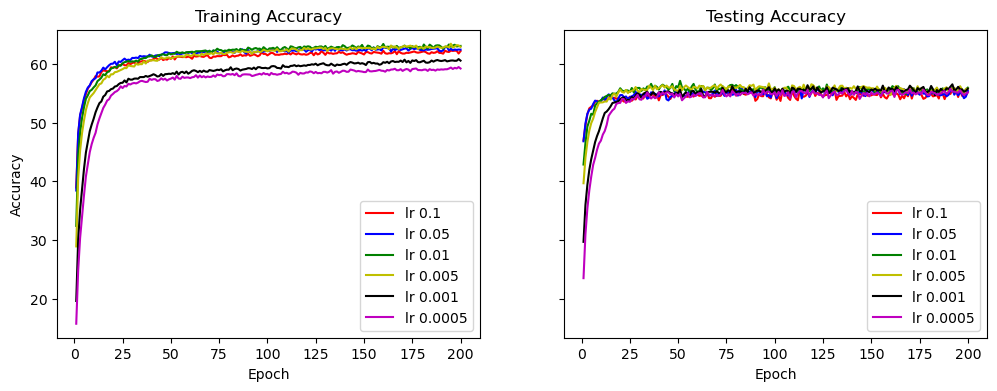

In [292]:
def plot_accuracy(trainers):
    train_accu = [trainer.train_precs for trainer in trainers]
    test_accu = [trainer.test_precs for trainer in trainers]
    lrs = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
    c = ['r-', 'b-', 'g-', 'y-', 'k-', 'm-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_accu):
        ax1.plot(x, y1, c[i], label='lr ' + str(lrs[i])) 
    
    for i, y2 in enumerate(test_accu):
        ax2.plot(x, y2, c[i], label='lr ' + str(lrs[i])) 

    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')

    ax2.set_title('Testing Accuracy')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='lower right')
    ax2.legend(loc='lower right')
    plt.show()

plot_accuracy([trainer, trainer5, trainer2, trainer4, trainer3, trainer6])

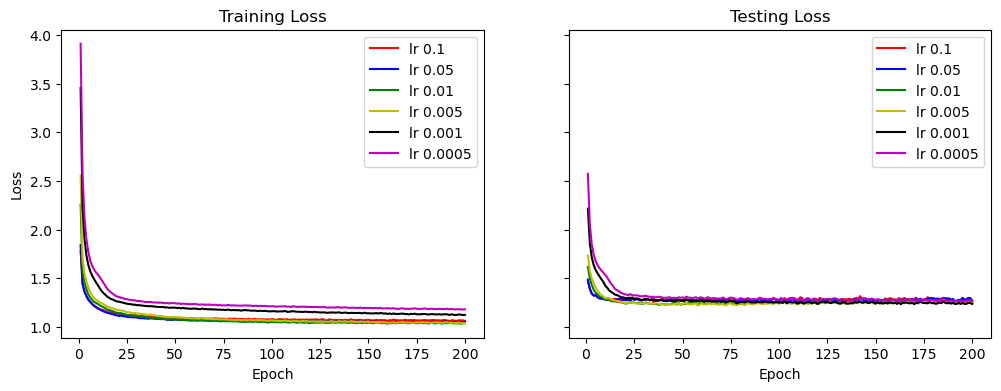

In [291]:
def plot_accuracy(trainers):
    train_losses = [trainer.train_losses for trainer in trainers]
    test_losses = [trainer.test_losses for trainer in trainers]
    lrs = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
    c = ['r-', 'b-', 'g-', 'y-', 'k-', 'm-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_losses):
        ax1.plot(x, y1, c[i], label='lr ' + str(lrs[i])) 
    
    for i, y2 in enumerate(test_losses):
        ax2.plot(x, y2, c[i], label='lr ' + str(lrs[i])) 

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2.set_title('Testing Loss')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    plt.show()

plot_accuracy([trainer, trainer5, trainer2, trainer4, trainer3, trainer6])

# 调bs

In [30]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 16
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer2 = Trainer(config, model, train_dataloader, test_dataloader)
trainer2.train()

Start time:  Thu Apr  4 23:44:39 2024
current lr 1.00000e-02
Epoch: [1][0/3124]	Time 0.006 (0.006)	Loss 3.8532 (3.8532)	Prec@1 25.000 (25.000)
Epoch: [1][625/3124]	Time 0.001 (0.002)	Loss 1.8422 (2.2802)	Prec@1 25.000 (29.243)
Epoch: [1][1250/3124]	Time 0.002 (0.002)	Loss 1.6495 (2.0239)	Prec@1 31.250 (33.054)
Epoch: [1][1875/3124]	Time 0.001 (0.002)	Loss 1.8696 (1.9184)	Prec@1 43.750 (35.015)
Epoch: [1][2500/3124]	Time 0.001 (0.002)	Loss 1.6753 (1.8606)	Prec@1 56.250 (36.096)
Epoch: [1][3124/3124]	Time 0.001 (0.002)	Loss 1.8750 (1.8275)	Prec@1 37.500 (36.638)
EPOCH: 1 train Results: Prec@1 36.638 Loss: 1.8275
Test: [0/624]	Time 0.001 (0.001)	Loss 1.1028 (1.1028)	Prec@1 50.000 (50.000)
Test: [624/624]	Time 0.000 (0.000)	Loss 1.7012 (1.5592)	Prec@1 25.000 (44.200)
EPOCH: 1 val Results: Prec@1 44.200 Loss: 1.5592
Best Prec@1: 44.200

current lr 1.00000e-02
Epoch: [2][0/3124]	Time 0.004 (0.004)	Loss 1.6005 (1.6005)	Prec@1 43.750 (43.750)
Epoch: [2][625/3124]	Time 0.001 (0.002)	Loss 1.6348

In [31]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 64
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer3 = Trainer(config, model, train_dataloader, test_dataloader)
trainer3.train()

Start time:  Thu Apr  4 23:58:10 2024
current lr 1.00000e-02
Epoch: [1][0/781]	Time 0.028 (0.028)	Loss 4.8473 (4.8473)	Prec@1 10.938 (10.938)
Epoch: [1][156/781]	Time 0.003 (0.002)	Loss 2.2352 (2.8937)	Prec@1 29.688 (25.995)
Epoch: [1][312/781]	Time 0.002 (0.002)	Loss 1.8190 (2.4371)	Prec@1 40.625 (29.907)
Epoch: [1][468/781]	Time 0.003 (0.002)	Loss 1.8261 (2.2225)	Prec@1 40.625 (32.513)
Epoch: [1][624/781]	Time 0.003 (0.002)	Loss 1.7003 (2.0929)	Prec@1 39.062 (34.163)
Epoch: [1][780/781]	Time 0.001 (0.002)	Loss 1.4736 (2.0061)	Prec@1 46.875 (35.509)
Epoch: [1][781/781]	Time 0.003 (0.002)	Loss 1.8692 (2.0060)	Prec@1 31.250 (35.508)
EPOCH: 1 train Results: Prec@1 35.508 Loss: 2.0060
Test: [0/156]	Time 0.001 (0.001)	Loss 1.5254 (1.5254)	Prec@1 40.625 (40.625)
Test: [156/156]	Time 0.000 (0.000)	Loss 1.4976 (1.5380)	Prec@1 31.250 (45.300)
EPOCH: 1 val Results: Prec@1 45.300 Loss: 1.5380
Best Prec@1: 45.300

current lr 1.00000e-02
Epoch: [2][0/781]	Time 0.002 (0.002)	Loss 1.4847 (1.4847)	Pr

In [32]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 256
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer4 = Trainer(config, model, train_dataloader, test_dataloader)
trainer4.train()

Start time:  Fri Apr  5 00:04:21 2024
current lr 1.00000e-02
Epoch: [1][0/195]	Time 0.023 (0.023)	Loss 5.4415 (5.4415)	Prec@1 9.375 (9.375)
Epoch: [1][39/195]	Time 0.003 (0.007)	Loss 2.7997 (3.9533)	Prec@1 23.047 (17.832)
Epoch: [1][78/195]	Time 0.006 (0.006)	Loss 2.4477 (3.3110)	Prec@1 29.297 (22.607)
Epoch: [1][117/195]	Time 0.005 (0.006)	Loss 2.1101 (2.9831)	Prec@1 32.031 (25.556)
Epoch: [1][156/195]	Time 0.004 (0.006)	Loss 2.0648 (2.7768)	Prec@1 32.031 (27.142)
Epoch: [1][195/195]	Time 0.002 (0.006)	Loss 1.8976 (2.6320)	Prec@1 37.500 (28.440)
EPOCH: 1 train Results: Prec@1 28.440 Loss: 2.6320
Test: [0/39]	Time 0.002 (0.002)	Loss 1.8507 (1.8507)	Prec@1 38.672 (38.672)
Test: [39/39]	Time 0.000 (0.001)	Loss 1.5348 (1.7647)	Prec@1 31.250 (39.100)
EPOCH: 1 val Results: Prec@1 39.100 Loss: 1.7647
Best Prec@1: 39.100

current lr 1.00000e-02
Epoch: [2][0/195]	Time 0.004 (0.004)	Loss 1.8571 (1.8571)	Prec@1 36.719 (36.719)
Epoch: [2][39/195]	Time 0.004 (0.006)	Loss 1.7678 (1.8140)	Prec@1 37.

In [33]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 512
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer5 = Trainer(config, model, train_dataloader, test_dataloader)
trainer5.train()

Start time:  Fri Apr  5 00:09:11 2024
current lr 1.00000e-02
Epoch: [1][0/97]	Time 0.014 (0.014)	Loss 5.5429 (5.5429)	Prec@1 11.719 (11.719)
Epoch: [1][19/97]	Time 0.023 (0.013)	Loss 3.7801 (4.6654)	Prec@1 17.383 (13.252)
Epoch: [1][38/97]	Time 0.014 (0.017)	Loss 3.0425 (3.9779)	Prec@1 23.047 (17.553)
Epoch: [1][57/97]	Time 0.008 (0.015)	Loss 2.6593 (3.5762)	Prec@1 26.367 (20.619)
Epoch: [1][76/97]	Time 0.008 (0.014)	Loss 2.5960 (3.3192)	Prec@1 26.758 (22.542)
Epoch: [1][95/97]	Time 0.007 (0.014)	Loss 2.2637 (3.1360)	Prec@1 32.422 (24.066)
Epoch: [1][97/97]	Time 0.005 (0.014)	Loss 2.3173 (3.1235)	Prec@1 26.488 (24.156)
EPOCH: 1 train Results: Prec@1 24.156 Loss: 3.1235
Test: [0/19]	Time 0.004 (0.004)	Loss 2.1026 (2.1026)	Prec@1 31.836 (31.836)
Test: [19/19]	Time 0.001 (0.003)	Loss 2.0898 (1.9851)	Prec@1 32.721 (34.910)
EPOCH: 1 val Results: Prec@1 34.910 Loss: 1.9851
Best Prec@1: 34.910

current lr 1.00000e-02
Epoch: [2][0/97]	Time 0.007 (0.007)	Loss 2.1610 (2.1610)	Prec@1 33.008 (33.0

In [34]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer6 = Trainer(config, model, train_dataloader, test_dataloader)
trainer6.train()

Start time:  Fri Apr  5 00:13:37 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.070 (0.070)	Loss 5.6750 (5.6750)	Prec@1 11.816 (11.816)
Epoch: [1][9/48]	Time 0.020 (0.026)	Loss 4.7818 (5.2282)	Prec@1 12.305 (11.035)
Epoch: [1][18/48]	Time 0.017 (0.024)	Loss 3.7836 (4.7092)	Prec@1 17.578 (12.911)
Epoch: [1][27/48]	Time 0.023 (0.025)	Loss 3.2810 (4.3349)	Prec@1 22.168 (15.008)
Epoch: [1][36/48]	Time 0.014 (0.024)	Loss 2.8565 (4.0358)	Prec@1 24.512 (16.918)
Epoch: [1][45/48]	Time 0.029 (0.024)	Loss 2.7543 (3.8056)	Prec@1 27.051 (18.663)
Epoch: [1][48/48]	Time 0.031 (0.025)	Loss 2.8402 (3.7480)	Prec@1 25.590 (19.118)
EPOCH: 1 train Results: Prec@1 19.118 Loss: 3.7480
Test: [0/9]	Time 0.008 (0.008)	Loss 2.4123 (2.4123)	Prec@1 29.004 (29.004)
Test: [9/9]	Time 0.005 (0.008)	Loss 2.3182 (2.3181)	Prec@1 29.592 (30.160)
EPOCH: 1 val Results: Prec@1 30.160 Loss: 2.3181
Best Prec@1: 30.160

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.025 (0.025)	Loss 2.6158 (2.6158)	Prec@1 28.516 (28.516)


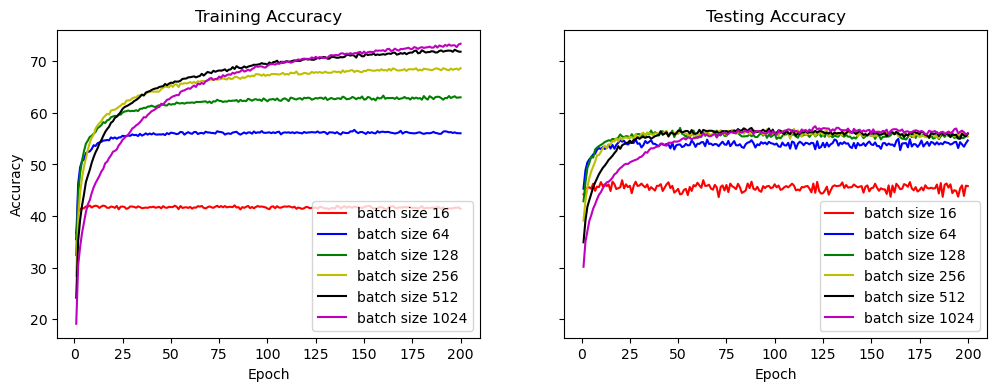

In [41]:
def plot_accuracy(trainers):
    train_accu = [trainer.train_precs for trainer in trainers]
    test_accu = [trainer.test_precs for trainer in trainers]
    lrs = [16, 64, 128, 256, 512, 1024]
    c = ['r-', 'b-', 'g-', 'y-', 'k-', 'm-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_accu):
        ax1.plot(x, y1, c[i], label='batch size ' + str(lrs[i])) 
    
    for i, y2 in enumerate(test_accu):
        ax2.plot(x, y2, c[i], label='batch size ' + str(lrs[i])) 

    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')

    ax2.set_title('Testing Accuracy')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='lower right')
    ax2.legend(loc='lower right')
    plt.show()

plot_accuracy([trainer2, trainer3, trainer, trainer4, trainer5, trainer6])

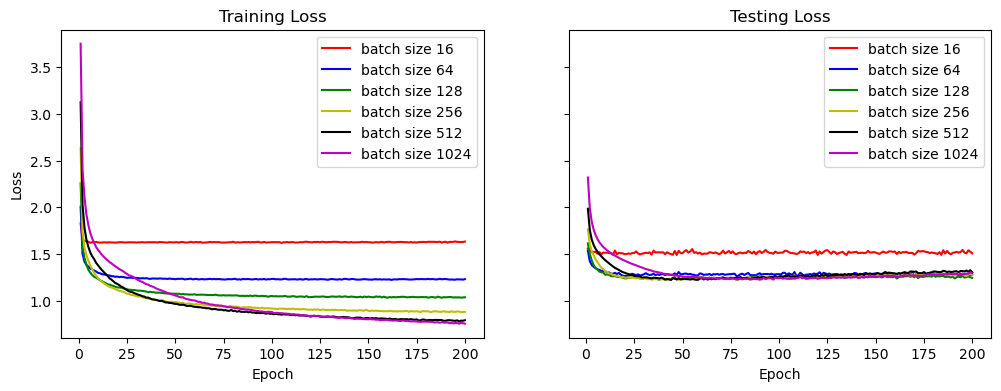

In [40]:
def plot_accuracy(trainers):
    train_losses = [trainer.train_losses for trainer in trainers]
    test_losses = [trainer.test_losses for trainer in trainers]
    lrs = [16, 64, 128, 256, 512, 1024]
    c = ['r-', 'b-', 'g-', 'y-', 'k-', 'm-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_losses):
        ax1.plot(x, y1, c[i], label='batch size ' + str(lrs[i])) 
    
    for i, y2 in enumerate(test_losses):
        ax2.plot(x, y2, c[i], label='batch size ' + str(lrs[i])) 

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2.set_title('Testing Loss')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    plt.show()

plot_accuracy([trainer2, trainer3, trainer, trainer4, trainer5, trainer6])

# Number of layers

In [42]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 128, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer = Trainer(config, model, train_dataloader, test_dataloader)
trainer.train()

Start time:  Fri Apr  5 00:37:24 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.060 (0.060)	Loss 6.1017 (6.1017)	Prec@1 8.691 (8.691)
Epoch: [1][9/48]	Time 0.023 (0.023)	Loss 5.0163 (5.6140)	Prec@1 13.281 (10.010)
Epoch: [1][18/48]	Time 0.028 (0.024)	Loss 3.9766 (5.0079)	Prec@1 14.160 (11.477)
Epoch: [1][27/48]	Time 0.041 (0.026)	Loss 3.4234 (4.5655)	Prec@1 15.625 (12.891)
Epoch: [1][36/48]	Time 0.030 (0.025)	Loss 3.0838 (4.2416)	Prec@1 19.727 (14.202)
Epoch: [1][45/48]	Time 0.018 (0.024)	Loss 2.9223 (3.9978)	Prec@1 20.020 (15.389)
Epoch: [1][48/48]	Time 0.021 (0.024)	Loss 2.9608 (3.9319)	Prec@1 20.165 (15.746)
EPOCH: 1 train Results: Prec@1 15.746 Loss: 3.9319
Test: [0/9]	Time 0.011 (0.011)	Loss 2.5364 (2.5364)	Prec@1 24.121 (24.121)
Test: [9/9]	Time 0.002 (0.005)	Loss 2.5098 (2.4635)	Prec@1 22.449 (24.100)
EPOCH: 1 val Results: Prec@1 24.100 Loss: 2.4635
Best Prec@1: 24.100

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.018 (0.018)	Loss 2.6894 (2.6894)	Prec@1 22.754 (22.754)
Ep

In [43]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 128, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn3', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout3', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu3'}}, 
    {'type': 'linear', 'params': {'name': 'fc4', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer2 = Trainer(config, model, train_dataloader, test_dataloader)
trainer2.train()

Start time:  Fri Apr  5 00:41:09 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.018 (0.018)	Loss 5.7441 (5.7441)	Prec@1 11.719 (11.719)
Epoch: [1][9/48]	Time 0.033 (0.026)	Loss 4.6315 (5.3044)	Prec@1 11.133 (10.479)
Epoch: [1][18/48]	Time 0.023 (0.024)	Loss 3.9461 (4.7820)	Prec@1 14.844 (11.863)
Epoch: [1][27/48]	Time 0.020 (0.026)	Loss 3.4503 (4.4230)	Prec@1 14.844 (12.866)
Epoch: [1][36/48]	Time 0.015 (0.024)	Loss 3.1546 (4.1460)	Prec@1 18.848 (14.086)
Epoch: [1][45/48]	Time 0.020 (0.025)	Loss 3.0063 (3.9408)	Prec@1 19.238 (14.876)
Epoch: [1][48/48]	Time 0.014 (0.025)	Loss 3.0054 (3.8840)	Prec@1 16.863 (15.174)
EPOCH: 1 train Results: Prec@1 15.174 Loss: 3.8840
Test: [0/9]	Time 0.005 (0.005)	Loss 2.4863 (2.4863)	Prec@1 21.582 (21.582)
Test: [9/9]	Time 0.003 (0.005)	Loss 2.5093 (2.4532)	Prec@1 21.684 (21.640)
EPOCH: 1 val Results: Prec@1 21.640 Loss: 2.4532
Best Prec@1: 21.640

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.020 (0.020)	Loss 2.8588 (2.8588)	Prec@1 20.117 (20.117)


In [44]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 128, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn3', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout3', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu3'}}, 
    {'type': 'linear', 'params': {'name': 'fc4', 'in_num': 128, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn4', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout4', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu4'}}, 
    {'type': 'linear', 'params': {'name': 'fc5', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer3 = Trainer(config, model, train_dataloader, test_dataloader)
trainer3.train()

Start time:  Fri Apr  5 00:45:06 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.026 (0.026)	Loss 6.0178 (6.0178)	Prec@1 8.984 (8.984)
Epoch: [1][9/48]	Time 0.031 (0.040)	Loss 4.6677 (5.3721)	Prec@1 10.059 (10.830)
Epoch: [1][18/48]	Time 0.026 (0.038)	Loss 4.0188 (4.8027)	Prec@1 14.062 (12.027)
Epoch: [1][27/48]	Time 0.046 (0.043)	Loss 3.6135 (4.4666)	Prec@1 16.016 (12.776)
Epoch: [1][36/48]	Time 0.027 (0.042)	Loss 3.2823 (4.2028)	Prec@1 16.504 (13.561)
Epoch: [1][45/48]	Time 0.047 (0.041)	Loss 3.1007 (4.0097)	Prec@1 17.676 (14.113)
Epoch: [1][48/48]	Time 0.036 (0.041)	Loss 3.1668 (3.9592)	Prec@1 15.684 (14.280)
EPOCH: 1 train Results: Prec@1 14.280 Loss: 3.9592
Test: [0/9]	Time 0.013 (0.013)	Loss 2.5029 (2.5029)	Prec@1 20.215 (20.215)
Test: [9/9]	Time 0.004 (0.015)	Loss 2.5133 (2.4946)	Prec@1 18.750 (19.880)
EPOCH: 1 val Results: Prec@1 19.880 Loss: 2.4946
Best Prec@1: 19.880

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.066 (0.066)	Loss 3.0313 (3.0313)	Prec@1 17.871 (17.871)
Ep

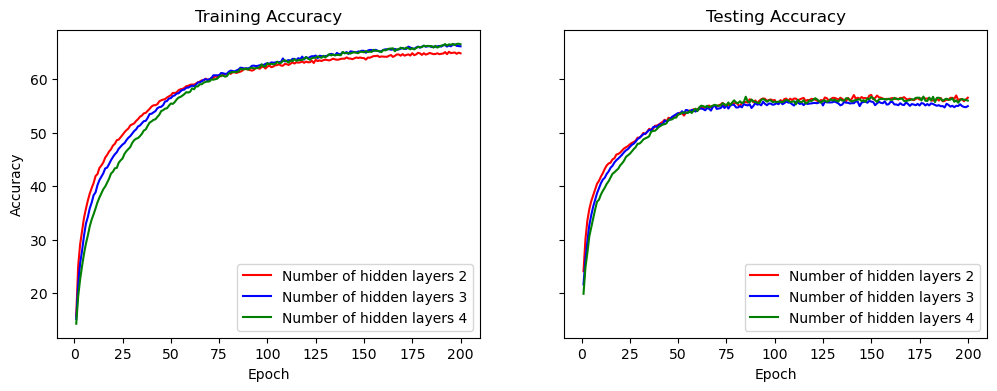

In [46]:
def plot_accuracy(trainers):
    train_accu = [trainer.train_precs for trainer in trainers]
    test_accu = [trainer.test_precs for trainer in trainers]
    lrs = [2, 3, 4]
    c = ['r-', 'b-', 'g-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_accu):
        ax1.plot(x, y1, c[i], label='Number of hidden layers ' + str(lrs[i])) 
    
    for i, y2 in enumerate(test_accu):
        ax2.plot(x, y2, c[i], label='Number of hidden layers ' + str(lrs[i])) 

    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')

    ax2.set_title('Testing Accuracy')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='lower right')
    ax2.legend(loc='lower right')
    plt.show()

plot_accuracy([trainer, trainer2, trainer3])

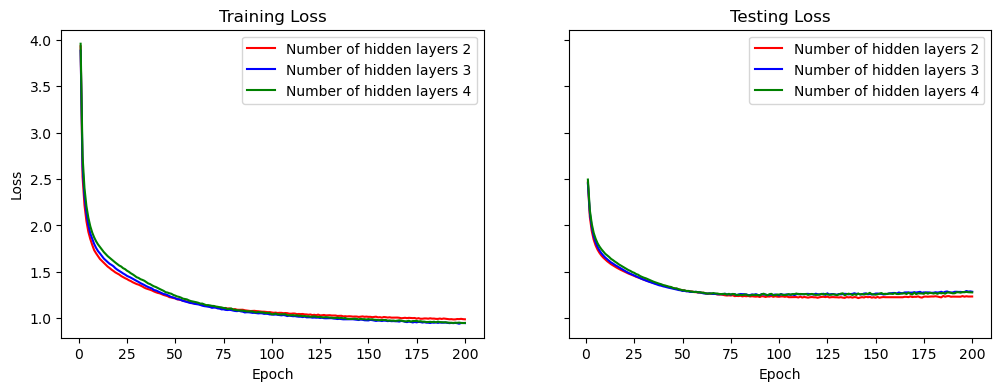

In [47]:
def plot_accuracy(trainers):
    train_losses = [trainer.train_losses for trainer in trainers]
    test_losses = [trainer.test_losses for trainer in trainers]
    lrs = [2, 3, 4]
    c = ['r-', 'b-', 'g-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_losses):
        ax1.plot(x, y1, c[i], label='Number of hidden layers ' + str(lrs[i])) 
    
    for i, y2 in enumerate(test_losses):
        ax2.plot(x, y2, c[i], label='Number of hidden layers ' + str(lrs[i])) 

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2.set_title('Testing Loss')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    plt.show()

plot_accuracy([trainer, trainer2, trainer3])

# Dimension of hidden layers

In [48]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer = Trainer(config, model, train_dataloader, test_dataloader)
trainer.train()

Start time:  Fri Apr  5 00:55:00 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.034 (0.034)	Loss 5.6750 (5.6750)	Prec@1 11.816 (11.816)
Epoch: [1][9/48]	Time 0.017 (0.033)	Loss 4.7818 (5.2282)	Prec@1 12.305 (11.035)
Epoch: [1][18/48]	Time 0.017 (0.033)	Loss 3.7836 (4.7092)	Prec@1 17.578 (12.911)
Epoch: [1][27/48]	Time 0.028 (0.031)	Loss 3.2810 (4.3349)	Prec@1 22.168 (15.008)
Epoch: [1][36/48]	Time 0.022 (0.029)	Loss 2.8565 (4.0358)	Prec@1 24.512 (16.918)
Epoch: [1][45/48]	Time 0.030 (0.028)	Loss 2.7543 (3.8056)	Prec@1 27.051 (18.663)
Epoch: [1][48/48]	Time 0.015 (0.027)	Loss 2.8402 (3.7480)	Prec@1 25.590 (19.118)
EPOCH: 1 train Results: Prec@1 19.118 Loss: 3.7480
Test: [0/9]	Time 0.006 (0.006)	Loss 2.4123 (2.4123)	Prec@1 29.004 (29.004)
Test: [9/9]	Time 0.005 (0.007)	Loss 2.3182 (2.3181)	Prec@1 29.592 (30.160)
EPOCH: 1 val Results: Prec@1 30.160 Loss: 2.3181
Best Prec@1: 30.160

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.015 (0.015)	Loss 2.6158 (2.6158)	Prec@1 28.516 (28.516)


In [50]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 128, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer2 = Trainer(config, model, train_dataloader, test_dataloader)
trainer2.train()

Start time:  Fri Apr  5 01:02:04 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.010 (0.010)	Loss 6.1017 (6.1017)	Prec@1 8.691 (8.691)
Epoch: [1][9/48]	Time 0.010 (0.016)	Loss 5.0163 (5.6140)	Prec@1 13.281 (10.010)
Epoch: [1][18/48]	Time 0.013 (0.018)	Loss 3.9766 (5.0079)	Prec@1 14.160 (11.477)
Epoch: [1][27/48]	Time 0.011 (0.016)	Loss 3.4234 (4.5655)	Prec@1 15.625 (12.891)
Epoch: [1][36/48]	Time 0.022 (0.017)	Loss 3.0838 (4.2416)	Prec@1 19.727 (14.202)
Epoch: [1][45/48]	Time 0.032 (0.018)	Loss 2.9223 (3.9978)	Prec@1 20.020 (15.389)
Epoch: [1][48/48]	Time 0.014 (0.018)	Loss 2.9608 (3.9319)	Prec@1 20.165 (15.746)
EPOCH: 1 train Results: Prec@1 15.746 Loss: 3.9319
Test: [0/9]	Time 0.012 (0.012)	Loss 2.5364 (2.5364)	Prec@1 24.121 (24.121)
Test: [9/9]	Time 0.002 (0.006)	Loss 2.5098 (2.4635)	Prec@1 22.449 (24.100)
EPOCH: 1 val Results: Prec@1 24.100 Loss: 2.4635
Best Prec@1: 24.100

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.019 (0.019)	Loss 2.6894 (2.6894)	Prec@1 22.754 (22.754)
Ep

In [58]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 64}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 64}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 64, 'out_num': 32}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 32}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 32, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer3 = Trainer(config, model, train_dataloader, test_dataloader)
trainer3.train()

Start time:  Fri Apr  5 15:35:19 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.158 (0.158)	Loss 3.3144 (3.3144)	Prec@1 10.449 (10.449)
Epoch: [1][9/48]	Time 0.118 (0.156)	Loss 3.1386 (3.1677)	Prec@1 11.328 (11.592)
Epoch: [1][18/48]	Time 0.112 (0.135)	Loss 2.8725 (3.0532)	Prec@1 11.719 (11.734)
Epoch: [1][27/48]	Time 0.098 (0.128)	Loss 2.7431 (2.9670)	Prec@1 13.086 (11.844)
Epoch: [1][36/48]	Time 0.088 (0.132)	Loss 2.6423 (2.8925)	Prec@1 13.184 (12.035)
Epoch: [1][45/48]	Time 0.118 (0.130)	Loss 2.5064 (2.8325)	Prec@1 13.574 (12.171)
Epoch: [1][48/48]	Time 0.113 (0.131)	Loss 2.5377 (2.8151)	Prec@1 15.094 (12.210)
EPOCH: 1 train Results: Prec@1 12.210 Loss: 2.8151
Test: [0/9]	Time 0.017 (0.017)	Loss 2.3824 (2.3824)	Prec@1 14.355 (14.355)
Test: [9/9]	Time 0.011 (0.016)	Loss 2.4637 (2.4081)	Prec@1 14.923 (14.670)
EPOCH: 1 val Results: Prec@1 14.670 Loss: 2.4081
Best Prec@1: 14.670

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.137 (0.137)	Loss 2.5007 (2.5007)	Prec@1 14.941 (14.941)


KeyboardInterrupt: 

In [51]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 512}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 512}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 512, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer4 = Trainer(config, model, train_dataloader, test_dataloader)
trainer4.train()

Start time:  Fri Apr  5 01:05:33 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.089 (0.089)	Loss 5.4671 (5.4671)	Prec@1 8.984 (8.984)
Epoch: [1][9/48]	Time 0.033 (0.049)	Loss 4.5582 (5.0006)	Prec@1 12.305 (11.035)
Epoch: [1][18/48]	Time 0.033 (0.049)	Loss 3.4331 (4.4615)	Prec@1 20.801 (13.728)
Epoch: [1][27/48]	Time 0.041 (0.048)	Loss 3.1306 (4.0722)	Prec@1 23.633 (16.560)
Epoch: [1][36/48]	Time 0.030 (0.046)	Loss 2.8231 (3.7826)	Prec@1 25.488 (18.768)
Epoch: [1][45/48]	Time 0.034 (0.045)	Loss 2.7165 (3.5788)	Prec@1 28.320 (20.695)
Epoch: [1][48/48]	Time 0.047 (0.045)	Loss 2.5746 (3.5249)	Prec@1 31.840 (21.198)
EPOCH: 1 train Results: Prec@1 21.198 Loss: 3.5249
Test: [0/9]	Time 0.015 (0.015)	Loss 2.2246 (2.2246)	Prec@1 32.031 (32.031)
Test: [9/9]	Time 0.007 (0.015)	Loss 2.2628 (2.1811)	Prec@1 32.143 (33.830)
EPOCH: 1 val Results: Prec@1 33.830 Loss: 2.1811
Best Prec@1: 33.830

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.045 (0.045)	Loss 2.4634 (2.4634)	Prec@1 31.445 (31.445)
Ep

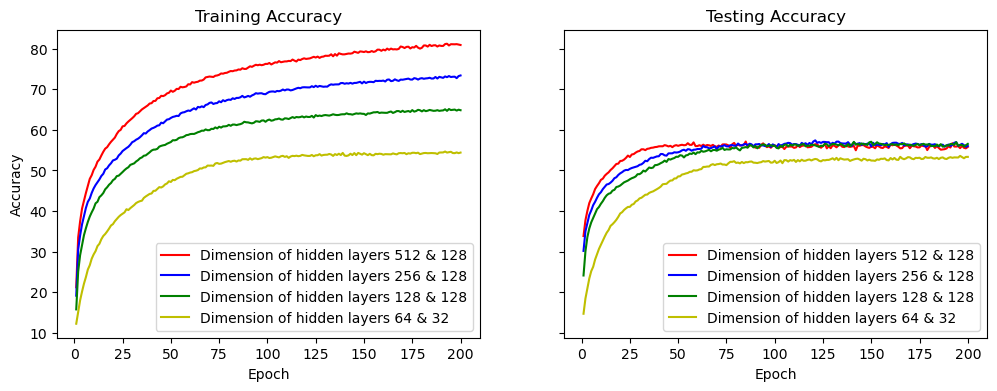

In [55]:
def plot_accuracy(trainers):
    train_accu = [trainer.train_precs for trainer in trainers]
    test_accu = [trainer.test_precs for trainer in trainers]
    lrs = ['512 & 128', '256 & 128', '128 & 128', '64 & 32']
    c = ['r-', 'b-', 'g-', 'y-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_accu):
        ax1.plot(x, y1, c[i], label='Dimension of hidden layers ' + lrs[i])
    
    for i, y2 in enumerate(test_accu):
        ax2.plot(x, y2, c[i], label='Dimension of hidden layers ' + lrs[i])

    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')

    ax2.set_title('Testing Accuracy')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='lower right')
    ax2.legend(loc='lower right')
    plt.show()

plot_accuracy([trainer4, trainer, trainer2, trainer3])

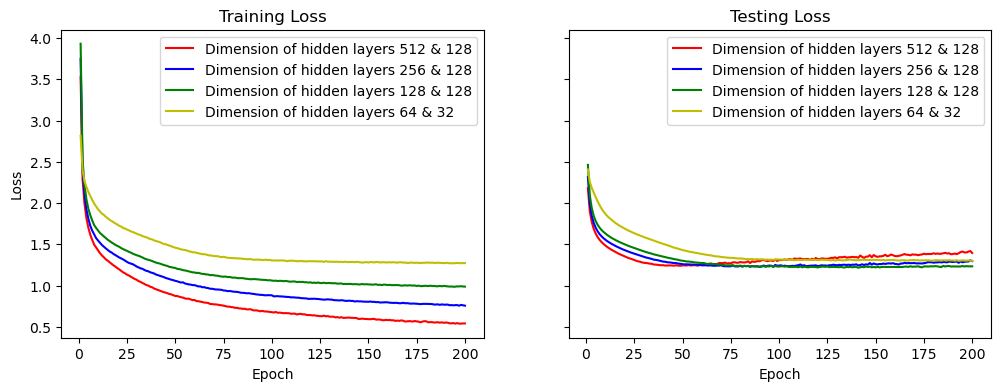

In [56]:
def plot_accuracy(trainers):
    train_losses = [trainer.train_losses for trainer in trainers]
    test_losses = [trainer.test_losses for trainer in trainers]
    lrs = ['512 & 128', '256 & 128', '128 & 128', '64 & 32']
    c = ['r-', 'b-', 'g-', 'y-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_losses):
        ax1.plot(x, y1, c[i], label='Dimension of hidden layers ' + lrs[i]) 
    
    for i, y2 in enumerate(test_losses):
        ax2.plot(x, y2, c[i], label='Dimension of hidden layers ' + lrs[i]) 

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2.set_title('Testing Loss')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    plt.show()

plot_accuracy([trainer4, trainer, trainer2, trainer3])

# activation

In [57]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    {'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer = Trainer(config, model, train_dataloader, test_dataloader)
trainer.train()

Start time:  Fri Apr  5 15:31:26 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.231 (0.231)	Loss 5.6862 (5.6862)	Prec@1 11.816 (11.816)
Epoch: [1][9/48]	Time 0.134 (0.187)	Loss 4.7894 (5.2429)	Prec@1 12.305 (11.211)
Epoch: [1][18/48]	Time 0.154 (0.185)	Loss 3.8461 (4.7425)	Prec@1 17.383 (12.932)
Epoch: [1][27/48]	Time 0.125 (0.183)	Loss 3.3577 (4.3809)	Prec@1 21.875 (14.941)
Epoch: [1][36/48]	Time 0.271 (0.180)	Loss 2.9378 (4.0896)	Prec@1 22.070 (16.646)
Epoch: [1][45/48]	Time 0.175 (0.178)	Loss 2.8140 (3.8610)	Prec@1 25.391 (18.345)
Epoch: [1][48/48]	Time 0.114 (0.176)	Loss 2.8850 (3.8032)	Prec@1 26.297 (18.778)
EPOCH: 1 train Results: Prec@1 18.778 Loss: 3.8032
Test: [0/9]	Time 0.029 (0.029)	Loss 2.4609 (2.4609)	Prec@1 28.027 (28.027)
Test: [9/9]	Time 0.026 (0.028)	Loss 2.3783 (2.3673)	Prec@1 29.337 (29.130)
EPOCH: 1 val Results: Prec@1 29.130 Loss: 2.3673
Best Prec@1: 29.130

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.148 (0.148)	Loss 2.6485 (2.6485)	Prec@1 28.320 (28.320)


KeyboardInterrupt: 

In [ ]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    {'type': 'sigmoid', 'params': {'name': 'sigmoid1'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    #{'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'sigmoid', 'params': {'name': 'sigmoid2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer2 = Trainer(config, model, train_dataloader, test_dataloader)
trainer2.train()

In [ ]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    #{'type': 'sigmoid', 'params': {'name': 'sigmoid1'}},  
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    #{'type': 'relu', 'params': {'name': 'relu2'}}, 
    #{'type': 'sigmoid', 'params': {'name': 'sigmoid2'}}, 
    {'type': 'leaky_relu', 'params': {'name': 'leaky_relu2', 'alpha': 0.1}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer3 = Trainer(config, model, train_dataloader, test_dataloader)
trainer3.train()

In [ ]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    #{'type': 'sigmoid', 'params': {'name': 'sigmoid1'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    #{'type': 'relu', 'params': {'name': 'relu1'}},  
    {'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    #{'type': 'relu', 'params': {'name': 'relu2'}}, 
    #{'type': 'sigmoid', 'params': {'name': 'sigmoid2'}}, 
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu2', 'alpha': 0.1}},
    {'type': 'tanh', 'params': {'name': 'tanh2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer4 = Trainer(config, model, train_dataloader, test_dataloader)
trainer4.train()

# optimizer

# dropout rate

# weight decay

In [119]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    {'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 1e-4,   # 5e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer2 = Trainer(config, model, train_dataloader, test_dataloader)
trainer2.train()

standardization
Start time:  Fri Apr  5 19:54:27 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.032 (0.032)	Loss 5.6862 (5.6862)	Prec@1 11.816 (11.816)
Epoch: [1][9/48]	Time 0.018 (0.030)	Loss 4.8041 (5.2506)	Prec@1 12.305 (11.211)
Epoch: [1][18/48]	Time 0.030 (0.027)	Loss 3.8688 (4.7558)	Prec@1 17.383 (12.921)
Epoch: [1][27/48]	Time 0.028 (0.029)	Loss 3.3859 (4.3983)	Prec@1 21.680 (14.914)
Epoch: [1][36/48]	Time 0.034 (0.030)	Loss 2.9693 (4.1102)	Prec@1 21.973 (16.599)
Epoch: [1][45/48]	Time 0.024 (0.029)	Loss 2.8476 (3.8840)	Prec@1 25.293 (18.302)
Epoch: [1][48/48]	Time 0.024 (0.029)	Loss 2.9216 (3.8270)	Prec@1 26.179 (18.730)
EPOCH: 1 train Results: Prec@1 18.730 Loss: 3.8270
Test: [0/9]	Time 0.004 (0.004)	Loss 2.4960 (2.4960)	Prec@1 28.027 (28.027)
Test: [9/9]	Time 0.004 (0.006)	Loss 2.4135 (2.4016)	Prec@1 29.209 (29.050)
EPOCH: 1 val Results: Prec@1 29.050 Loss: 2.4016
Best Prec@1: 29.050

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.018 (0.018)	Loss 2.6818 (2.6818)	Prec@1 

In [120]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    {'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-3,   # 5e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer3 = Trainer(config, model, train_dataloader, test_dataloader)
trainer3.train()

standardization
Start time:  Fri Apr  5 20:01:13 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.031 (0.031)	Loss 5.6862 (5.6862)	Prec@1 11.816 (11.816)
Epoch: [1][9/48]	Time 0.031 (0.030)	Loss 4.6272 (5.1572)	Prec@1 12.402 (11.221)
Epoch: [1][18/48]	Time 0.019 (0.030)	Loss 3.6048 (4.5981)	Prec@1 17.676 (13.060)
Epoch: [1][27/48]	Time 0.019 (0.038)	Loss 3.0688 (4.1947)	Prec@1 22.559 (15.231)
Epoch: [1][36/48]	Time 0.024 (0.035)	Loss 2.6287 (3.8740)	Prec@1 24.023 (17.106)
Epoch: [1][45/48]	Time 0.055 (0.041)	Loss 2.4940 (3.6249)	Prec@1 27.148 (18.899)
Epoch: [1][48/48]	Time 0.020 (0.039)	Loss 2.5358 (3.5611)	Prec@1 27.005 (19.340)
EPOCH: 1 train Results: Prec@1 19.340 Loss: 3.5611
Test: [0/9]	Time 0.005 (0.005)	Loss 2.1634 (2.1634)	Prec@1 28.809 (28.809)
Test: [9/9]	Time 0.004 (0.007)	Loss 2.0889 (2.0830)	Prec@1 29.719 (30.320)
EPOCH: 1 val Results: Prec@1 30.320 Loss: 2.0830
Best Prec@1: 30.320

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.019 (0.019)	Loss 2.3347 (2.3347)	Prec@1 

In [121]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    {'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 1e-3,   # 5e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer4 = Trainer(config, model, train_dataloader, test_dataloader)
trainer4.train()

standardization
Start time:  Fri Apr  5 20:10:44 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.026 (0.026)	Loss 5.6862 (5.6862)	Prec@1 11.816 (11.816)
Epoch: [1][9/48]	Time 0.022 (0.032)	Loss 4.7710 (5.2332)	Prec@1 12.305 (11.211)
Epoch: [1][18/48]	Time 0.107 (0.034)	Loss 3.8180 (4.7260)	Prec@1 17.285 (12.932)
Epoch: [1][27/48]	Time 0.165 (0.043)	Loss 3.3231 (4.3593)	Prec@1 21.875 (14.959)
Epoch: [1][36/48]	Time 0.033 (0.041)	Loss 2.8998 (4.0642)	Prec@1 22.266 (16.678)
Epoch: [1][45/48]	Time 0.047 (0.039)	Loss 2.7736 (3.8327)	Prec@1 25.586 (18.381)
Epoch: [1][48/48]	Time 0.026 (0.038)	Loss 2.8409 (3.7741)	Prec@1 26.415 (18.818)
EPOCH: 1 train Results: Prec@1 18.818 Loss: 3.7741
Test: [0/9]	Time 0.006 (0.006)	Loss 2.4191 (2.4191)	Prec@1 28.320 (28.320)
Test: [9/9]	Time 0.005 (0.010)	Loss 2.3372 (2.3267)	Prec@1 29.464 (29.300)
EPOCH: 1 val Results: Prec@1 29.300 Loss: 2.3267
Best Prec@1: 29.300

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.025 (0.025)	Loss 2.6081 (2.6081)	Prec@1 

In [122]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    {'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 0,   # 5e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer5 = Trainer(config, model, train_dataloader, test_dataloader)
trainer5.train()

standardization
Start time:  Fri Apr  5 20:15:11 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.026 (0.026)	Loss 5.6862 (5.6862)	Prec@1 11.816 (11.816)
Epoch: [1][9/48]	Time 0.051 (0.032)	Loss 4.8078 (5.2525)	Prec@1 12.305 (11.211)
Epoch: [1][18/48]	Time 0.030 (0.032)	Loss 3.8745 (4.7591)	Prec@1 17.188 (12.906)
Epoch: [1][27/48]	Time 0.078 (0.037)	Loss 3.3929 (4.4027)	Prec@1 21.680 (14.903)
Epoch: [1][36/48]	Time 0.055 (0.039)	Loss 2.9770 (4.1154)	Prec@1 21.973 (16.583)
Epoch: [1][45/48]	Time 0.024 (0.038)	Loss 2.8560 (3.8898)	Prec@1 25.195 (18.287)
Epoch: [1][48/48]	Time 0.013 (0.037)	Loss 2.9309 (3.8330)	Prec@1 25.943 (18.710)
EPOCH: 1 train Results: Prec@1 18.710 Loss: 3.8330
Test: [0/9]	Time 0.005 (0.005)	Loss 2.5050 (2.5050)	Prec@1 28.125 (28.125)
Test: [9/9]	Time 0.003 (0.005)	Loss 2.4223 (2.4104)	Prec@1 29.464 (29.070)
EPOCH: 1 val Results: Prec@1 29.070 Loss: 2.4104
Best Prec@1: 29.070

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.054 (0.054)	Loss 2.6902 (2.6902)	Prec@1 

In [123]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    {'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 1e-5,   # 5e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer6 = Trainer(config, model, train_dataloader, test_dataloader)
trainer6.train()

standardization
Start time:  Fri Apr  5 20:21:24 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.038 (0.038)	Loss 5.6862 (5.6862)	Prec@1 11.816 (11.816)
Epoch: [1][9/48]	Time 0.027 (0.033)	Loss 4.8074 (5.2523)	Prec@1 12.305 (11.211)
Epoch: [1][18/48]	Time 0.025 (0.026)	Loss 3.8739 (4.7588)	Prec@1 17.188 (12.906)
Epoch: [1][27/48]	Time 0.042 (0.032)	Loss 3.3922 (4.4023)	Prec@1 21.680 (14.903)
Epoch: [1][36/48]	Time 0.183 (0.041)	Loss 2.9762 (4.1149)	Prec@1 21.973 (16.588)
Epoch: [1][45/48]	Time 0.027 (0.039)	Loss 2.8550 (3.8892)	Prec@1 25.195 (18.294)
Epoch: [1][48/48]	Time 0.028 (0.039)	Loss 2.9299 (3.8324)	Prec@1 25.943 (18.714)
EPOCH: 1 train Results: Prec@1 18.714 Loss: 3.8324
Test: [0/9]	Time 0.005 (0.005)	Loss 2.5041 (2.5041)	Prec@1 28.027 (28.027)
Test: [9/9]	Time 0.005 (0.008)	Loss 2.4213 (2.4095)	Prec@1 29.209 (29.040)
EPOCH: 1 val Results: Prec@1 29.040 Loss: 2.4095
Best Prec@1: 29.040

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.026 (0.026)	Loss 2.6894 (2.6894)	Prec@1 

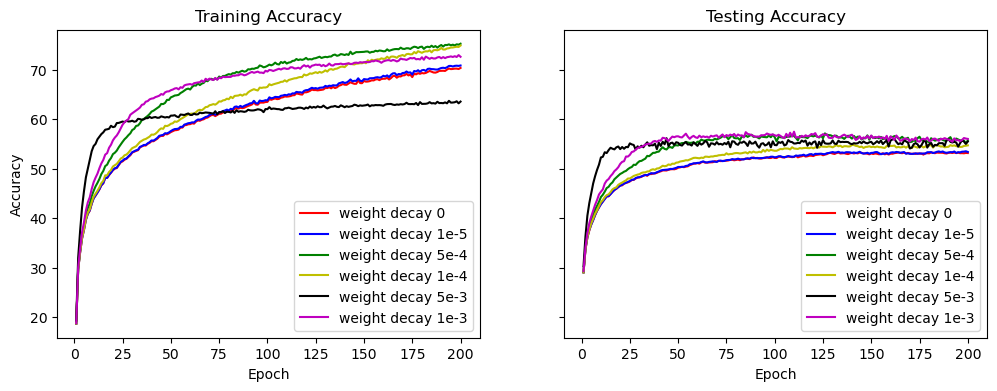

In [124]:
def plot_accuracy(trainers):
    train_accu = [trainer.train_precs for trainer in trainers]
    test_accu = [trainer.test_precs for trainer in trainers]
    lrs = ['weight decay 0', 'weight decay 1e-5', 'weight decay 5e-4', 'weight decay 1e-4', 'weight decay 5e-3', 'weight decay 1e-3']
    c = ['r-', 'b-', 'g-', 'y-', 'k-', 'm-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_accu):
        ax1.plot(x, y1, c[i], label=lrs[i])
    
    for i, y2 in enumerate(test_accu):
        ax2.plot(x, y2, c[i], label=lrs[i])

    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')

    ax2.set_title('Testing Accuracy')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='lower right')
    ax2.legend(loc='lower right')
    plt.show()

plot_accuracy([trainer5, trainer6, trainer, trainer2, trainer3, trainer4])

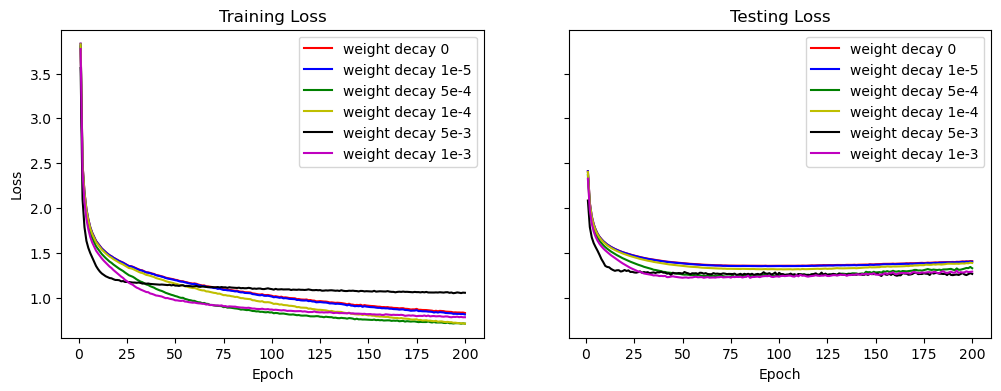

In [125]:
def plot_accuracy(trainers):
    train_losses = [trainer.train_losses for trainer in trainers]
    test_losses = [trainer.test_losses for trainer in trainers]
    lrs = ['weight decay 0', 'weight decay 1e-5', 'weight decay 5e-4', 'weight decay 1e-4', 'weight decay 5e-3', 'weight decay 1e-3']
    c = ['r-', 'b-', 'g-', 'y-', 'k-', 'm-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_losses):
        ax1.plot(x, y1, c[i], label=lrs[i])
    
    for i, y2 in enumerate(test_losses):
        ax2.plot(x, y2, c[i], label=lrs[i]) 

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2.set_title('Testing Loss')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    plt.show()

plot_accuracy([trainer5, trainer6, trainer, trainer2, trainer3, trainer4])

# scheduler

In [72]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    {'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': 'cos', 
    'pre-process': 'norm',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer_cos = Trainer(config, model, train_dataloader, test_dataloader)
trainer_cos.train()

cos <__main__.CosineLR object at 0x155d9db90>
Start time:  Fri Apr  5 16:46:10 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.024 (0.024)	Loss 5.6862 (5.6862)	Prec@1 11.816 (11.816)
Epoch: [1][9/48]	Time 0.033 (0.030)	Loss 4.7894 (5.2429)	Prec@1 12.305 (11.211)
Epoch: [1][18/48]	Time 0.061 (0.030)	Loss 3.8461 (4.7425)	Prec@1 17.383 (12.932)
Epoch: [1][27/48]	Time 0.082 (0.030)	Loss 3.3577 (4.3809)	Prec@1 21.875 (14.941)
Epoch: [1][36/48]	Time 0.035 (0.033)	Loss 2.9378 (4.0896)	Prec@1 22.070 (16.646)
Epoch: [1][45/48]	Time 0.023 (0.032)	Loss 2.8140 (3.8610)	Prec@1 25.391 (18.345)
Epoch: [1][48/48]	Time 0.143 (0.034)	Loss 2.8850 (3.8032)	Prec@1 26.297 (18.778)
EPOCH: 1 train Results: Prec@1 18.778 Loss: 3.8032
Test: [0/9]	Time 0.051 (0.051)	Loss 2.4609 (2.4609)	Prec@1 28.027 (28.027)
Test: [9/9]	Time 0.011 (0.015)	Loss 2.3783 (2.3673)	Prec@1 29.337 (29.130)
EPOCH: 1 val Results: Prec@1 29.130 Loss: 2.3673
Best Prec@1: 29.130

current lr 9.99938e-03
Epoch: [2][0/48]	Time 0.040 (0.040

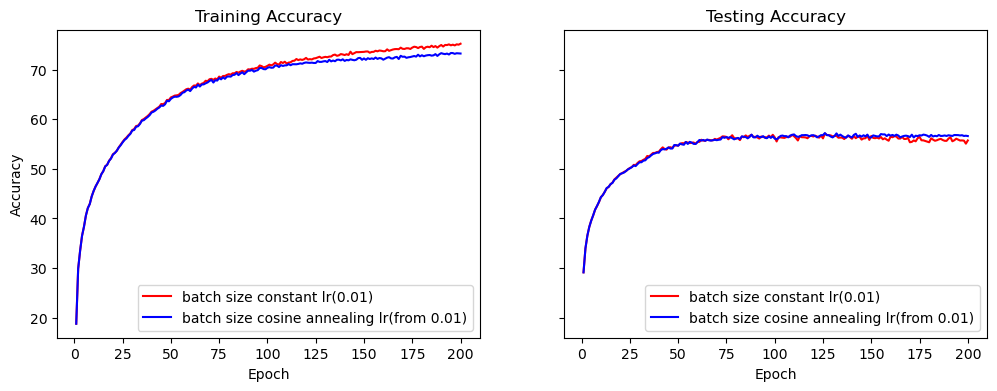

In [74]:
def plot_accuracy(trainers):
    train_accu = [trainer.train_precs for trainer in trainers]
    test_accu = [trainer.test_precs for trainer in trainers]
    lrs = ['constant lr(0.01)', 'cosine annealing lr(from 0.01)']
    c = ['r-', 'b-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_accu):
        ax1.plot(x, y1, c[i], label='batch size ' + str(lrs[i])) 
    
    for i, y2 in enumerate(test_accu):
        ax2.plot(x, y2, c[i], label='batch size ' + str(lrs[i])) 

    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')

    ax2.set_title('Testing Accuracy')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='lower right')
    ax2.legend(loc='lower right')
    plt.show()

plot_accuracy([trainer, trainer_cos])

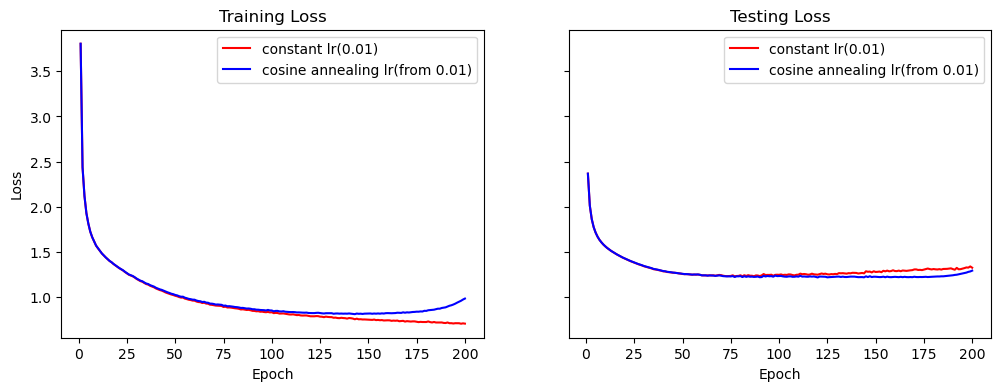

In [75]:
def plot_accuracy(trainers):
    train_losses = [trainer.train_losses for trainer in trainers]
    test_losses = [trainer.test_losses for trainer in trainers]
    lrs = ['constant lr(0.01)', 'cosine annealing lr(from 0.01)']
    c = ['r-', 'b-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_losses):
        ax1.plot(x, y1, c[i], label=lrs[i]) 
    
    for i, y2 in enumerate(test_losses):
        ax2.plot(x, y2, c[i], label=lrs[i]) 

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2.set_title('Testing Loss')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    plt.show()

plot_accuracy([trainer, trainer_cos])

# pre-processing

In [110]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model

file_path = './Assignment1-Dataset/'

train_X = np.load(file_path + 'train_data.npy')
train_y = np.load(file_path + 'train_label.npy')
test_X = np.load(file_path + 'test_data.npy')
test_y = np.load(file_path + 'test_label.npy')

layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    {'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': 'min-max',      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer_minmax = Trainer(config, model, train_dataloader, test_dataloader)
trainer_minmax.train()

min-max normalization
Start time:  Fri Apr  5 17:21:06 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.019 (0.019)	Loss 5.7103 (5.7103)	Prec@1 11.133 (11.133)
Epoch: [1][9/48]	Time 0.021 (0.034)	Loss 4.7373 (5.2096)	Prec@1 12.695 (11.240)
Epoch: [1][18/48]	Time 0.028 (0.029)	Loss 3.7699 (4.6854)	Prec@1 17.578 (13.441)
Epoch: [1][27/48]	Time 0.036 (0.030)	Loss 3.3227 (4.3193)	Prec@1 24.512 (15.754)
Epoch: [1][36/48]	Time 0.037 (0.035)	Loss 2.8718 (4.0297)	Prec@1 24.219 (17.591)
Epoch: [1][45/48]	Time 0.030 (0.036)	Loss 2.8099 (3.8107)	Prec@1 28.125 (19.262)
Epoch: [1][48/48]	Time 0.026 (0.035)	Loss 2.8529 (3.7536)	Prec@1 26.061 (19.656)
EPOCH: 1 train Results: Prec@1 19.656 Loss: 3.7536
Test: [0/9]	Time 0.005 (0.005)	Loss 2.5061 (2.5061)	Prec@1 28.711 (28.711)
Test: [9/9]	Time 0.005 (0.007)	Loss 2.4660 (2.4279)	Prec@1 28.699 (28.990)
EPOCH: 1 val Results: Prec@1 28.990 Loss: 2.4279
Best Prec@1: 28.990

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.022 (0.022)	Loss 2.6264 (2.6264)	P

In [111]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model

file_path = './Assignment1-Dataset/'

train_X = np.load(file_path + 'train_data.npy')
train_y = np.load(file_path + 'train_label.npy')
test_X = np.load(file_path + 'test_data.npy')
test_y = np.load(file_path + 'test_label.npy')

layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.1}},
    # {'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    {'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.1}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,   # 5e-4, 2e-4, 1e-4, 5e-3, 0
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',  # adam, sgd
    'scheduler': None, 
    'pre-process': None,      # min-max, norm, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer_nopre = Trainer(config, model, train_dataloader, test_dataloader)
trainer_nopre.train()

Start time:  Fri Apr  5 17:26:30 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.074 (0.074)	Loss 5.4443 (5.4443)	Prec@1 11.133 (11.133)
Epoch: [1][9/48]	Time 0.020 (0.024)	Loss 3.8457 (4.5644)	Prec@1 18.848 (14.258)
Epoch: [1][18/48]	Time 0.018 (0.021)	Loss 3.1979 (3.9771)	Prec@1 25.879 (18.873)
Epoch: [1][27/48]	Time 0.024 (0.021)	Loss 2.8079 (3.6526)	Prec@1 26.074 (21.104)
Epoch: [1][36/48]	Time 0.016 (0.020)	Loss 2.4274 (3.4024)	Prec@1 30.371 (23.015)
Epoch: [1][45/48]	Time 0.021 (0.020)	Loss 2.4720 (3.2265)	Prec@1 27.734 (24.127)
Epoch: [1][48/48]	Time 0.017 (0.020)	Loss 2.4298 (3.1791)	Prec@1 29.127 (24.464)
EPOCH: 1 train Results: Prec@1 24.464 Loss: 3.1791
Test: [0/9]	Time 0.006 (0.006)	Loss 1.9909 (1.9909)	Prec@1 33.984 (33.984)
Test: [9/9]	Time 0.003 (0.006)	Loss 2.0067 (1.9768)	Prec@1 34.439 (35.660)
EPOCH: 1 val Results: Prec@1 35.660 Loss: 1.9768
Best Prec@1: 35.660

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.020 (0.020)	Loss 2.2723 (2.2723)	Prec@1 29.688 (29.688)


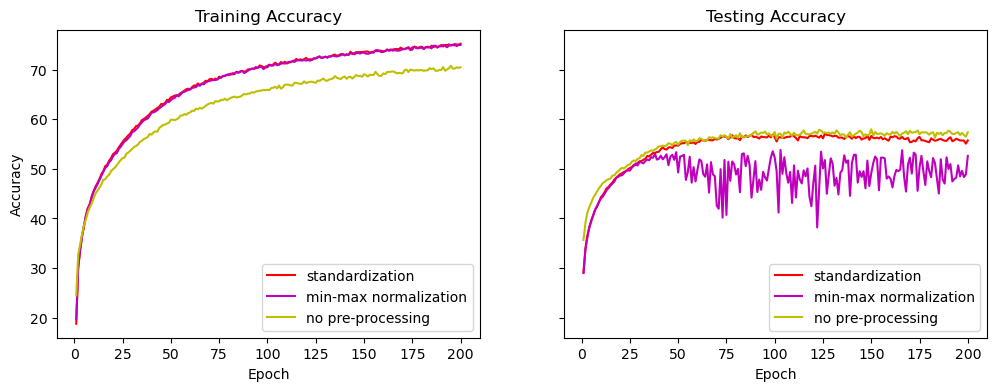

In [112]:
def plot_accuracy(trainers):
    train_accu = [trainer.train_precs for trainer in trainers]
    test_accu = [trainer.test_precs for trainer in trainers]
    lrs = ['standardization', 'min-max normalization', 'no pre-processing']
    c = ['r-', 'm-', 'y-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_accu):
        ax1.plot(x, y1, c[i], label=lrs[i]) 
    
    for i, y2 in enumerate(test_accu):
        ax2.plot(x, y2, c[i], label=lrs[i])

    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')

    ax2.set_title('Testing Accuracy')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='lower right')
    ax2.legend(loc='lower right')
    plt.show()

plot_accuracy([trainer, trainer_minmax, trainer_nopre])

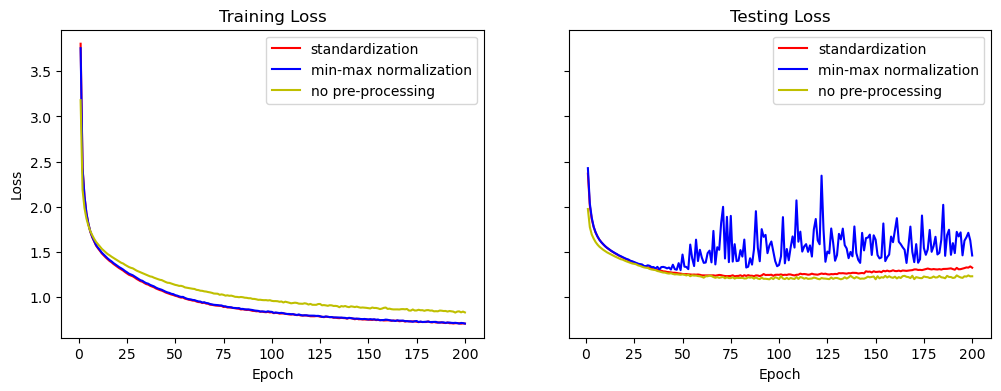

In [113]:
def plot_accuracy(trainers):
    train_losses = [trainer.train_losses for trainer in trainers]
    test_losses = [trainer.test_losses for trainer in trainers]
    lrs = ['standardization', 'min-max normalization', 'no pre-processing']
    c = ['r-', 'b-', 'y-']
    x = [i + 1 for i in range(trainer.epochs)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    for i, y1 in enumerate(train_losses):
        ax1.plot(x, y1, c[i], label=lrs[i]) 
    
    for i, y2 in enumerate(test_losses):
        ax2.plot(x, y2, c[i], label=lrs[i]) 

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2.set_title('Testing Loss')
    ax2.set_xlabel('Epoch')

    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    plt.show()

plot_accuracy([trainer, trainer_minmax, trainer_nopre])

# weight init